# Etape 0 - Récupération de la source et pré-traitement

In [1]:
#import des modules necessaires
import os
import time
import datetime as dt
import requests
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import missingno as msno
import sklearn.impute
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import preprocessing

from matplotlib.collections import LineCollection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
#definition variables
dossierData='Datas'
fichierDist='https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip'
dossierExport=dossierData+'/Etape0'
fichierDnld=dossierExport+'/FichierOrigine.zip'
fichierTemp=dossierExport+'/__MACOSX'
fichierOrig=dossierExport+'/fr.openfoodfacts.org.products.csv'
fichierDest=dossierExport+'/new.fr.openfoodfacts.org.products.csv'

In [3]:
def CreationDir(dossierExport):
    if not os.path.exists(dossierExport):
        os.makedirs(dossierExport)

In [4]:
# on cree le repertoire Data si il n'existe pas
CreationDir(dossierExport)

# on recupere le fichier d'origine et on le dezippe
response = requests.get(fichierDist)
if response.status_code == 200:
    with open(fichierDnld, "wb") as file:
        file.write(response.content)
        print("Fichier téléchargé avec succès!")
        shutil.unpack_archive(fichierDnld, dossierExport)
        if os.path.exists(fichierOrig):
            print("Fichier décompressé avec succès!")
            if os.path.exists(fichierTemp):
                shutil.rmtree(fichierTemp)
        else:
            print("Erreur de décompression!")
else:
    print("Erreur de téléchargement du fichier!")

Fichier téléchargé avec succès!
Fichier décompressé avec succès!


--> Fichier comportant 320773 lignes (-1 pour le titre)

In [5]:
# traitement du fichier origine pour gestion retour chariots
with open(fichierOrig, "r", newline='\n') as dataOrig:
    with open(fichierDest, "w", newline='\n') as dataDest:
        for lineOrig in dataOrig:
            lineOrig = lineOrig.replace('\r', '')
            dataDest.write(lineOrig)

--> Fichier comportant 320750 lignes (-1 pour le titre)

# Etape 1 - Nettoyage et filtre features et produits

In [6]:
#definition variables
dossierImport=dossierData+'/Etape0'
fichierImp=dossierImport+'/new.fr.openfoodfacts.org.products.csv'
dossierExport=dossierData+'/Etape1'

# on cree le repertoire Data si il n'existe pas
CreationDir(dossierExport)

In [7]:
def analyseDataFrame(Data,MiseEnForme=0,DoublonCle=0,DoublonAction=0,DoublonCsv=0,DoublonAff=0,Retour=0):
    """
    # Analyse du dataframe
    # Liste des paramètres :
    #  - Data          : nom du dataframe a analyser
    #  - MiseEnForme   : recherche les colonne vides ('Unnamed') et les corrige [0/1]
    #  - DoublonCle    : si recherche de doublons, clé sur laquelle on cherche (str ou liste) [0/nom(s) de colonne(s)]
    #  - DoublonAction : action a mener sur les doublons [0/purge]
    #  - DoublonCsv    : si besoin d'un export au format csv [nom du fichier sans .csv]
    #  - DoublonAff    : doit on afficher les doublons [0/1]
    #  - Retour        : doit on renvoyer le dataframe en sortie [0/1]
    """
    nomData = [name for name in globals() if globals()[name] is Data]
    nomDf = ''.join(nomData)
    print('\n-- nom du DataFrame analysé :',nomDf)
    # Recherche si colone vide en fin de ligne et on la retire
    if MiseEnForme != 0:
        print('-- Recherche de colonne vides dans le DataFrame :')
        ColsEmpty=0
        for nomColonne in Data.columns:
            if "Unnamed" in nomColonne:
                ColsEmpty+=1
                print('suppression de la colonne vide :',nomColonne)
                Data.pop(nomColonne)
        if ColsEmpty == 0:
            print('aucune colonne vide trouvée')
    # Verification de la taille du Df
    print('-- Structure du DataFrame :')
    nb_enr_total=Data.shape[0]
    nb_var_total=Data.shape[1]
    print('nombre d\'individus :',nb_enr_total)
    print('nombre variables :',nb_var_total)
    # Recherche des doublons
    if DoublonCle != 0 :
        if Data.duplicated(subset=DoublonCle).any() == True:
            DataNew=Data.copy()
            print('-- présence de doublons dans la feature \''+DoublonCle+'\'') 
            Result=pd.concat(g for _, g in Data.groupby(DoublonCle) if len(g) > 1)
            nb_doublon=Result.shape[0]
            nb_enr_total=Data.shape[0]
            prct_doublon=round((nb_doublon*100)/nb_enr_total,3)
            print('   nombre doublons :',nb_doublon)
            print('   pourcentage doublons :',prct_doublon,'%')
            # affichage des doublons
            if DoublonAff !=0:
                display(Result)
            # action sur les doublons
            if DoublonAction !=0:
                # Purge des doublons
                if DoublonAction == 'purge':
                    print('      -- purge des',nb_doublon,'doublons')
                    DataNew = DataNew[DataNew.index.isin(Result.index) == False]
                    nb_ind_rest=DataNew.shape[0]
                    print('      nombre d\'individus restantes :',nb_ind_rest)
            # export csv des doublons
            if DoublonCsv != 0 :
                print('      -- export des doublons dans '+dossierExport+'/'+DoublonCsv+'.csv')
                Result.to_csv(dossierExport+"/"+DoublonCsv+'.csv', index=False)
            # renvoi du nouveau Df
            if Retour != 0:
                print('      -- renvoi du DataFrame modifié')
                return DataNew
        else :
            print('-- pas de doublon dans la feature \''+DoublonCle+'\'')

In [8]:
def PurgeGeneraleDonnees(Datas,Indexes):
    """
    # Purge générale d'individus sur plusieurs dataframes
    # Liste des paramètres :
    #  - Data       : nom du ou des dataframe(s) a modifier [nom(s) dataframe(s)]
    #  - Indexes    : indexes a purger [liste des indexes]
    """
    print('------------------ Purge Générale des Données ------------------')
    if len(Indexes) > 0:
        for Data in Datas:
            #récupération du nom du dataframe
            nomData = [name for name in globals() if globals()[name] is Data]
            nomDf = ''.join(nomData)
            print('\n-- suppression de ',len(Indexes),' indexes du DataFrame ',nomDf)
            Data.drop(Indexes, inplace=True)
            GestionVariables(Data,AffVars=0)
    else:
            print('aucun index a supprimer !')

In [9]:
def GestionVariables(Data,FichierCsv=0,Filtre=0,FiltreCsv=0,AffVars=0,Retour=0):
    """
    # Affiche le type de variables, le nombre de valeurs nulles et le %de valeurs nulles
    # Liste des paramètres :
    #  - Data       : nom du dataframe a analyser
    #  - FichierCsv : si besoin d'un export au format csv [0/nom du fichier sans .csv]
    #  - Filtre     : si filtre a appliquer entrer une valeur en % a partir duquel filtrer les variables [0-99]
    #  - FiltreCsv  : si besoin d'un export des variables filtrées au format csv [0/nom du fichier sans .csv]
    #  - AffVars    : doit on afficher le tableau des variables [0/1]
    #  - Retour     : doit on renvoyer le dataframe en sortie [0/1]
    """
    nomData = [name for name in globals() if globals()[name] is Data]
    nomDf = ''.join(nomData)
    print('\n-- nom du DataFrame analysé :',nomDf)

    nb_enr_total=Data.shape[0]
    nb_var_total=Data.shape[1]
    print('nombre d\'individus :',nb_enr_total)
    print('nombre variables :',nb_var_total)

    variables=pd.DataFrame(Data.dtypes)
    variables.reset_index(inplace=True)
    variables.rename(columns={'index': 'variable',0: 'type'}, inplace=True)
    nbNulle = Data.isnull().sum()
    variables_nulles = nbNulle.index
    nbNulles=pd.DataFrame(variables_nulles, columns=['variable'])
    nbNulles['nulles']=nbNulle.values
    nbNulles['%nulles']=round(nbNulles['nulles']*100/nb_enr_total)
    nbNulles = nbNulles.astype({'%nulles': int})

    #display(nbNulles)
    variables[['nulles','%nulles']]=nbNulles[['nulles','%nulles']]
    variables.sort_values(by='nulles',ascending=True, inplace=True)
    if Filtre != 0:
        DataNew=Data.copy()
        print('\n -- filtrage des variables au dessus de '+str(Filtre)+'% nulles')
        Vars2Del=variables.loc[variables['%nulles']>=Filtre]
        #display(Vars2Del)
        nb_var_filtre=Vars2Del.shape[0]
        gain_var=round((nb_var_filtre*100)/nb_var_total,3)
        print('   nombre de variables filtées :',nb_var_filtre)
        print('   gain sur les variables :',gain_var,'%')
        for Var2Del in Vars2Del['variable']:
            DataNew.pop(Var2Del)
        nb_var_rest=DataNew.shape[1]
        print('   nombre de variables restantes :',nb_var_rest)
        variables = variables[variables.variable.isin(Vars2Del['variable']) == False]
        if FiltreCsv != 0 :
            print('   -- export des variables supprimées dans '+dossierExport+"/"+FiltreCsv+'.csv')
            Vars2Del.to_csv(dossierExport+"/"+FiltreCsv+'.csv', index=False)
    if FichierCsv != 0 :
        print('\n -- export du type des variables et fiabilité dans '+dossierExport+"/"+FichierCsv+'.csv')
        variables.to_csv(dossierExport+"/"+FichierCsv+'.csv', index=False)
    if AffVars !=0 :
        print('\n -- affichage du type des variables et fiabilité :')
        display(variables)
    if Retour !=0 :
        print('\n -- renvoi du DataFrame modifié')
        return DataNew

In [10]:
def ConvertToInt(Data,Colonne):
    """
    # Converti le type de variables en Int
    # Liste des paramètres :
    #  - Data       : nom du dataframe a modifier
    #  - Colonne    : nom de la colonne a convertir 
    """
    Data[Colonne]=Data[Colonne].apply(lambda x:int(x))

In [11]:
# Import du fichier corrigé
dfDataInput = pd.read_csv(fichierImp, sep='\t', lineterminator='\n', encoding='utf-8', low_memory=False)

In [12]:
dfDataInput.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
dfDataInput.tail()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
320744,9948282780603,http://world-fr.openfoodfacts.org/produit/9948...,openfoodfacts-contributors,1490631299,2017-03-27T16:14:59Z,1491244498,2017-04-03T18:34:58Z,Tomato & ricotta,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320745,99567453,http://world-fr.openfoodfacts.org/produit/9956...,usda-ndb-import,1489059076,2017-03-09T11:31:16Z,1491244499,2017-04-03T18:34:59Z,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
320746,9970229501521,http://world-fr.openfoodfacts.org/produit/9970...,tomato,1422099377,2015-01-24T11:36:17Z,1491244499,2017-04-03T18:34:59Z,乐吧泡菜味薯片,Leba pickle flavor potato chips,50 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320747,9980282863788,http://world-fr.openfoodfacts.org/produit/9980...,openfoodfacts-contributors,1492340089,2017-04-16T10:54:49Z,1492340089,2017-04-16T10:54:49Z,Tomates aux Vermicelles,NaN,67g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320748,999990026839,http://world-fr.openfoodfacts.org/produit/9999...,usda-ndb-import,1489072709,2017-03-09T15:18:29Z,1491244499,2017-04-03T18:34:59Z,"Sugar Free Drink Mix, Peach Tea",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
analyseDataFrame(dfDataInput,MiseEnForme=1)


-- nom du DataFrame analysé : dfDataInput
-- Recherche de colonne vides dans le DataFrame :
aucune colonne vide trouvée
-- Structure du DataFrame :
nombre d'individus : 320749
nombre variables : 162


In [15]:
GestionVariables(dfDataInput,FichierCsv='VarsdfDataInput',AffVars=1)


-- nom du DataFrame analysé : dfDataInput
nombre d'individus : 320749
nombre variables : 162

 -- export du type des variables et fiabilité dans Datas/Etape1/VarsdfDataInput.csv

 -- affichage du type des variables et fiabilité :


,variable,type,nulles,%nulles
0,code,object,0,0
1,url,object,0,0
3,created_t,int64,0,0
5,last_modified_t,int64,0,0
6,last_modified_datetime,object,0,0
...,...,...,...,...
94,elaidic-acid_100g,float64,320749,100
95,gondoic-acid_100g,float64,320749,100
96,mead-acid_100g,float64,320749,100
76,behenic-acid_100g,float64,320749,100


 ---->  listing des [variables et fiabilité](Data/Etape1/VarsdfDataInput.csv)

## Mise en conformité RGPD

In [16]:
# la feature contient le site d'apport de l'information mais peut aussi contenir 
# le pseudo de l'utilisateur ayant renseigné pour la première fois l'information
dfDataInput=dfDataInput.drop(labels='creator',axis=1)

## Verification des doublons

In [17]:
#recherche de doublons sur colonne Code
analyseDataFrame(dfDataInput,DoublonCle='code',DoublonAff=0)


-- nom du DataFrame analysé : dfDataInput
-- Structure du DataFrame :
nombre d'individus : 320749
nombre variables : 161
-- pas de doublon dans la feature 'code'


In [18]:
# conversion des codes barres en INT pour codes commençant par des 0
ConvertToInt(dfDataInput,'code')

In [19]:
#nouvelle recherche de doublons sur colonne Code
analyseDataFrame(dfDataInput,DoublonCle='code',DoublonAff=0)


-- nom du DataFrame analysé : dfDataInput
-- Structure du DataFrame :
nombre d'individus : 320749
nombre variables : 161
-- présence de doublons dans la feature 'code'
   nombre doublons : 351
   pourcentage doublons : 0.109 %


## Filtre variables vides

In [20]:
dfDataClean=dfDataInput.copy()

In [21]:
#suppression des variables avec 99% de valeurs vides et plus
dfDataClean=GestionVariables(dfDataClean,Filtre=75,FiltreCsv='DelVariables',AffVars=0,Retour=1)


-- nom du DataFrame analysé : dfDataClean
nombre d'individus : 320749
nombre variables : 161

 -- filtrage des variables au dessus de 75% nulles
   nombre de variables filtées : 112
   gain sur les variables : 69.565 %
   nombre de variables restantes : 49
   -- export des variables supprimées dans Datas/Etape1/DelVariables.csv

 -- renvoi du DataFrame modifié


## Gestion des doublons "Code"

In [22]:
#verification des doublons
analyseDataFrame(dfDataClean,DoublonCle='code',DoublonAff=0)


-- nom du DataFrame analysé : dfDataClean
-- Structure du DataFrame :
nombre d'individus : 320749
nombre variables : 49
-- présence de doublons dans la feature 'code'
   nombre doublons : 351
   pourcentage doublons : 0.109 %


les doublons representent 0,1% nous allons donc les ignorer

In [23]:
#on lance une purge des doublons
dfDataClean=analyseDataFrame(dfDataClean,DoublonCle='code',DoublonAction='purge',DoublonCsv='DelDoublonsCode',DoublonAff=0,Retour=1)


-- nom du DataFrame analysé : dfDataClean
-- Structure du DataFrame :
nombre d'individus : 320749
nombre variables : 49
-- présence de doublons dans la feature 'code'
   nombre doublons : 351
   pourcentage doublons : 0.109 %
      -- purge des 351 doublons
      nombre d'individus restantes : 320398
      -- export des doublons dans Datas/Etape1/DelDoublonsCode.csv
      -- renvoi du DataFrame modifié


In [24]:
GestionVariables(dfDataClean,FichierCsv='VarsdfDataClean',AffVars=0)


-- nom du DataFrame analysé : dfDataClean
nombre d'individus : 320398
nombre variables : 49

 -- export du type des variables et fiabilité dans Datas/Etape1/VarsdfDataClean.csv


## Création de 5 dataframes Tags / SpecsFr / Nutriments / Energy / General

In [25]:
# Separation des Tags
Tags=[colonne for colonne in dfDataClean.columns if colonne.endswith('_tags')]
dfTags=dfDataClean.loc[:,Tags]
GestionVariables(dfTags,FichierCsv='VarsdfTags',AffVars=0)


-- nom du DataFrame analysé : dfTags
nombre d'individus : 320398
nombre variables : 5

 -- export du type des variables et fiabilité dans Datas/Etape1/VarsdfTags.csv


In [26]:
# Separation des SpecsFr
SpecsFr=[colonne for colonne in dfDataClean.columns if colonne.endswith('_fr')]
dfSpecsFr=dfDataClean.loc[:,SpecsFr]
GestionVariables(dfSpecsFr,FichierCsv='VarsdfSpecsFr',AffVars=0)


-- nom du DataFrame analysé : dfSpecsFr
nombre d'individus : 320398
nombre variables : 6

 -- export du type des variables et fiabilité dans Datas/Etape1/VarsdfSpecsFr.csv


In [27]:
# Separation des nutriments
Nutriments_100g=[colonne for colonne in dfDataClean.columns if colonne.endswith('_100g')]
dfNutriments=dfDataClean.loc[:,Nutriments_100g]
GestionVariables(dfNutriments,FichierCsv='VarsdfNutriments',AffVars=0)


-- nom du DataFrame analysé : dfNutriments
nombre d'individus : 320398
nombre variables : 17

 -- export du type des variables et fiabilité dans Datas/Etape1/VarsdfNutriments.csv


In [28]:
# Split des informations energetiques
# on enlève variables contenant le terme score ou energie car ils ne sont pas dans la meme unité
DropVars=[colonne for colonne in dfNutriments.columns if ('score' in colonne) or ('energy' in colonne)] 
PnnsVars=[colonne for colonne in dfDataClean.columns if ('pnns_' in colonne)] 
dfEnergy=dfNutriments[DropVars].copy()
dfEnergy=dfEnergy.join(dfDataClean[PnnsVars], on=None, how='left', sort=False, validate=None)
dfNutriments=dfNutriments.drop(labels=DropVars,axis=1)
GestionVariables(dfEnergy,FichierCsv='VarsdfEnergy',AffVars=0)
GestionVariables(dfNutriments,FichierCsv='VarsdfNutriments',AffVars=0)


-- nom du DataFrame analysé : dfEnergy
nombre d'individus : 320398
nombre variables : 5

 -- export du type des variables et fiabilité dans Datas/Etape1/VarsdfEnergy.csv

-- nom du DataFrame analysé : dfNutriments
nombre d'individus : 320398
nombre variables : 14

 -- export du type des variables et fiabilité dans Datas/Etape1/VarsdfNutriments.csv


In [29]:
# Separation des informations generales
dfGeneral=dfDataClean.copy()
DropVars=Nutriments_100g + SpecsFr + Tags + PnnsVars
dfGeneral=dfGeneral.drop(labels=DropVars,axis=1)
GestionVariables(dfGeneral,FichierCsv='VarsdfGeneral',AffVars=0)


-- nom du DataFrame analysé : dfGeneral
nombre d'individus : 320398
nombre variables : 19

 -- export du type des variables et fiabilité dans Datas/Etape1/VarsdfGeneral.csv


In [30]:
dfNutriments.tail()

,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
320744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
320746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320748,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN


## Sauvegarde des DataFrames

In [31]:
# Sauvegarde des Df
dfDataInput.to_csv(dossierExport+'/dfDataInput.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfDataInput=pd.DataFrame()
dfDataClean.to_csv(dossierExport+'/dfDataClean.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfDataClean=pd.DataFrame()
dfGeneral.to_csv(dossierExport+'/dfGeneral.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfNutriments.to_csv(dossierExport+'/dfNutriments.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfSpecsFr.to_csv(dossierExport+'/dfSpecsFr.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfTags.to_csv(dossierExport+'/dfTags.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfEnergy.to_csv(dossierExport+'/dfEnergy.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')

# Etape 2 - Identifier et traiter valeurs aberrantes

In [32]:
# definition variables
dossierImport=dossierData+'/Etape1'
dossierExport=dossierData+'/Etape2'

# on cree le repertoire Data si il n'existe pas
CreationDir(dossierExport)

## mise en forme des titres de colonnes pour les graphes

In [33]:
# Changement des noms de colonnes de dfNutriments pour affichage graph
Cols_orig=dfNutriments.columns.tolist()
Cols_new=[]
for col100g in Cols_orig:
    Cols_new.append(col100g.replace("_100g", ""))
dfNutriments=dfNutriments.set_axis(Cols_new, axis=1)
GestionVariables(dfNutriments,FichierCsv='dfNutriments',AffVars=0)


-- nom du DataFrame analysé : dfNutriments
nombre d'individus : 320398
nombre variables : 14

 -- export du type des variables et fiabilité dans Datas/Etape2/dfNutriments.csv


In [34]:
# Changement des noms de colonnes de dfEnergy pour affichage graph
Cols_orig=dfEnergy.columns.tolist()
Cols_new=[]
for col100g in Cols_orig:
    Cols_new.append(col100g.replace("_100g", ""))
dfEnergy=dfEnergy.set_axis(Cols_new, axis=1)
GestionVariables(dfEnergy,FichierCsv='VarsdfEnergy',AffVars=0)


-- nom du DataFrame analysé : dfEnergy
nombre d'individus : 320398
nombre variables : 5

 -- export du type des variables et fiabilité dans Datas/Etape2/VarsdfEnergy.csv


## valeurs nutriments négatives et >100 pour 100g

In [35]:
# suppression des valeurs négatives pour 100g
valeurNeg=dfNutriments.values < 0 
# suppression des valeurs >100g pour 100g
valeurOvr=dfNutriments.values > 100
Index2del=dfNutriments.loc[(valeurNeg)|(valeurOvr)].index
Index2del = np.unique(Index2del).tolist()
print('Valeurs aberrantes : ',len(Index2del))
Datas=[dfGeneral,dfNutriments,dfSpecsFr,dfTags,dfEnergy]
PurgeGeneraleDonnees(Datas,Index2del)

Valeurs aberrantes :  219
------------------ Purge Générale des Données ------------------

-- suppression de  219  indexes du DataFrame  dfGeneral

-- nom du DataFrame analysé : dfGeneral
nombre d'individus : 320179
nombre variables : 19

-- suppression de  219  indexes du DataFrame  dfNutriments

-- nom du DataFrame analysé : dfNutriments
nombre d'individus : 320179
nombre variables : 14

-- suppression de  219  indexes du DataFrame  dfSpecsFr

-- nom du DataFrame analysé : dfSpecsFr
nombre d'individus : 320179
nombre variables : 6

-- suppression de  219  indexes du DataFrame  dfTags

-- nom du DataFrame analysé : dfTags
nombre d'individus : 320179
nombre variables : 5

-- suppression de  219  indexes du DataFrame  dfEnergy

-- nom du DataFrame analysé : dfEnergy
nombre d'individus : 320179
nombre variables : 5


## valeurs nutriments à 100 pour 100g 

In [36]:
def RechercheOccurence(nom,categ):
    Car2Rempl = {",": " ", "-": " ", "\'": " "}
    nom=str(nom)
    for Car, Rempl in Car2Rempl.items():
        nom = nom.replace(Car, Rempl)
    mots=nom.split()
    for i in mots:
        if i.lower() in dictionnaire[categ]:
            return 0
    return 1

Index2del=[]
Cols=dfNutriments.columns.tolist()
dictionnaire={}
dictionnaire['fat']=['oil','huile','huiles','beurre','ghee','shortening','saindoux','graisse','fat','lard'] # graisses
dictionnaire['carbohydrates']=['sucre','sugar','sweetener','candy'] # glucides
dictionnaire['sugars']=['sucre','sugar'] # sucres
dictionnaire['salt']=['sel','salt']
dictionnaire['proteins']=['gelatin']
for compos in Cols:
    seuil_max=99 
    nutri_max=pd.DataFrame(dfNutriments[compos].loc[dfNutriments[compos]>seuil_max])
    nb_max=int(nutri_max.count().iloc[0])
    print('nombre de produits dépassant la valeur max de '+compos+' :',nb_max)
    nutri_max=nutri_max.join(dfGeneral['product_name'], on=None, how='left', sort=False, validate=None)
    if compos in dictionnaire:
        print('--> dictionnaire de filtre pour ',compos)
        nutri_max['delete']=nutri_max['product_name'].apply(lambda x: RechercheOccurence(x,compos))
    else:
        nutri_max['delete']=1
    nb_del=int(nutri_max.loc[nutri_max['delete']==1].count().iloc[0])
    if nb_del > 0 :
        print('----> nombre de suppression : ',nb_del)
        Index2del.extend(nutri_max.loc[nutri_max['delete']==1].index.tolist())
        nutri_max.loc[nutri_max['delete']==1].to_csv(dossierExport+'/max_'+compos+'.csv')
#Index2del=list(dict.fromkeys(Index2del))
Index2del=np.unique(Index2del).tolist()
print('Nombre total de suppressions : ',len(Index2del))
PurgeGeneraleDonnees(Datas,Index2del)

nombre de produits dépassant la valeur max de fat : 1332
--> dictionnaire de filtre pour  fat
----> nombre de suppression :  177
nombre de produits dépassant la valeur max de saturated-fat : 12
----> nombre de suppression :  12
nombre de produits dépassant la valeur max de trans-fat : 1
----> nombre de suppression :  1
nombre de produits dépassant la valeur max de cholesterol : 0
nombre de produits dépassant la valeur max de carbohydrates : 2648
--> dictionnaire de filtre pour  carbohydrates
----> nombre de suppression :  1276
nombre de produits dépassant la valeur max de sugars : 1051
--> dictionnaire de filtre pour  sugars
----> nombre de suppression :  555
nombre de produits dépassant la valeur max de fiber : 10
----> nombre de suppression :  10
nombre de produits dépassant la valeur max de proteins : 12
--> dictionnaire de filtre pour  proteins
----> nombre de suppression :  8
nombre de produits dépassant la valeur max de salt : 192
--> dictionnaire de filtre pour  salt
----> nombr

In [37]:
dfNutriments.describe()

,fat,saturated-fat,trans-fat,cholesterol,carbohydrates,sugars,fiber,proteins,salt,sodium,vitamin-a,vitamin-c,calcium,iron
count,241680.000000,228271.000000,142167.000000,143071.000000,241385.000000,243014.000000,199765.000000,257716.000000,253311.000000,253264.000000,136699.000000,139930.000000,140195.000000,139604.000000
mean,12.741772,5.121897,0.066916,0.019721,31.660180,15.637839,2.835512,7.122210,1.576854,0.620923,0.000397,0.013410,0.101379,0.003548
std,17.375612,7.848969,0.910755,0.319105,28.721082,20.577535,4.529083,8.140423,6.163950,2.426954,0.073507,0.373984,0.523624,0.213180
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,5.910000,1.300000,0.000000,0.710000,0.063500,0.025000,0.000000,0.000000,0.000000,0.000000
50%,5.100000,1.800000,0.000000,0.000000,20.000000,5.600000,1.500000,4.800000,0.589280,0.232000,0.000000,0.000000,0.036000,0.001030
75%,20.000000,7.140000,0.000000,0.021000,57.780000,23.530000,3.600000,10.000000,1.379220,0.543000,0.000107,0.003700,0.107000,0.002400
max,100.000000,99.000000,83.000000,95.238000,100.000000,100.000000,99.000000,100.000000,100.000000,39.370079,26.700000,63.200000,82.000000,50.000000


## valeurs énergétiques >3900Kj pour 100g

In [38]:
max_energy=pd.DataFrame(dfEnergy.loc[dfEnergy['energy']>3900]['energy'])
print('produits depassant les 3900Kj pour 100g :',max_energy['energy'].count())
max_energy=max_energy.join(dfGeneral['product_name'], on=None, how='left', sort=False, validate=None)
max_energy.to_csv(dossierExport+"/max_energy.csv", index=True)
Index2del=max_energy.index
PurgeGeneraleDonnees(Datas,Index2del)

produits depassant les 3900Kj pour 100g : 151
------------------ Purge Générale des Données ------------------

-- suppression de  151  indexes du DataFrame  dfGeneral

-- nom du DataFrame analysé : dfGeneral
nombre d'individus : 318244
nombre variables : 19

-- suppression de  151  indexes du DataFrame  dfNutriments

-- nom du DataFrame analysé : dfNutriments
nombre d'individus : 318244
nombre variables : 14

-- suppression de  151  indexes du DataFrame  dfSpecsFr

-- nom du DataFrame analysé : dfSpecsFr
nombre d'individus : 318244
nombre variables : 6

-- suppression de  151  indexes du DataFrame  dfTags

-- nom du DataFrame analysé : dfTags
nombre d'individus : 318244
nombre variables : 5

-- suppression de  151  indexes du DataFrame  dfEnergy

-- nom du DataFrame analysé : dfEnergy
nombre d'individus : 318244
nombre variables : 5


## valeurs Fer > 0.07g pour 100g

In [39]:
max_iron=pd.DataFrame(dfNutriments.loc[dfNutriments['iron']>0.07]['iron'])
print('produits depassant les 500mg pour 100g :',max_iron['iron'].count())
max_iron=max_iron.join(dfGeneral['product_name'], on=None, how='left', sort=False, validate=None)
max_iron.to_csv(dossierExport+"/max_iron.csv", index=True)
Index2del=max_iron.index
PurgeGeneraleDonnees(Datas,Index2del)

produits depassant les 500mg pour 100g : 48
------------------ Purge Générale des Données ------------------

-- suppression de  48  indexes du DataFrame  dfGeneral

-- nom du DataFrame analysé : dfGeneral
nombre d'individus : 318196
nombre variables : 19

-- suppression de  48  indexes du DataFrame  dfNutriments

-- nom du DataFrame analysé : dfNutriments
nombre d'individus : 318196
nombre variables : 14

-- suppression de  48  indexes du DataFrame  dfSpecsFr

-- nom du DataFrame analysé : dfSpecsFr
nombre d'individus : 318196
nombre variables : 6

-- suppression de  48  indexes du DataFrame  dfTags

-- nom du DataFrame analysé : dfTags
nombre d'individus : 318196
nombre variables : 5

-- suppression de  48  indexes du DataFrame  dfEnergy

-- nom du DataFrame analysé : dfEnergy
nombre d'individus : 318196
nombre variables : 5


## Filtre données Main_categories_FR avec valeurs autre que français

In [40]:
dfSpecsFr.loc[dfSpecsFr['main_category_fr'].str.contains(':', na=False)].to_csv(dossierExport+"/DelCategNoFr.csv", index=True)

Index2del=dfSpecsFr.loc[dfSpecsFr['main_category_fr'].str.contains(':', na=False)].index
print('Valeurs non Fr : ',len(Index2del))

Datas=[dfGeneral,dfNutriments,dfSpecsFr,dfTags,dfEnergy]
PurgeGeneraleDonnees(Datas,Index2del)

Valeurs non Fr :  2881
------------------ Purge Générale des Données ------------------

-- suppression de  2881  indexes du DataFrame  dfGeneral

-- nom du DataFrame analysé : dfGeneral
nombre d'individus : 315315
nombre variables : 19

-- suppression de  2881  indexes du DataFrame  dfNutriments

-- nom du DataFrame analysé : dfNutriments
nombre d'individus : 315315
nombre variables : 14

-- suppression de  2881  indexes du DataFrame  dfSpecsFr

-- nom du DataFrame analysé : dfSpecsFr
nombre d'individus : 315315
nombre variables : 6

-- suppression de  2881  indexes du DataFrame  dfTags

-- nom du DataFrame analysé : dfTags
nombre d'individus : 315315
nombre variables : 5

-- suppression de  2881  indexes du DataFrame  dfEnergy

-- nom du DataFrame analysé : dfEnergy
nombre d'individus : 315315
nombre variables : 5


## Identification et quantification des catégories possibles

In [41]:
ValuesCateg=pd.DataFrame(dfSpecsFr['main_category_fr'].value_counts(sort=True,ascending=False))
ValuesCateg.index.rename('Categories', inplace=True)
ValuesCateg.rename(columns={'count': 'Occurences'}, inplace=True)
ValuesCateg['SommeCum']=ValuesCateg.Occurences.cumsum()
ValuesCateg['id']=range(1,len(ValuesCateg)+1)
DistribCateg=pd.DataFrame(ValuesCateg['Occurences'].value_counts().sort_index())
DistribCateg.reset_index(inplace=True)
DistribCateg.rename(columns={'count': 'Nombre'}, inplace=True)
DistribCateg['Valeur']=DistribCateg['Occurences']*DistribCateg['Nombre']
DistribCateg['SommeCum']=DistribCateg.Valeur.cumsum()
DistribCateg['Categ']=DistribCateg.Nombre.sort_index(ascending=False).cumsum()

In [42]:
ValuesCateg

,Occurences,SommeCum,id
Categories,,,
Boissons,6049,6049,1
Epicerie,2897,8946,2
Chocolats,2786,11732,3
Aliments et boissons à base de végétaux,2739,14471,4
Conserves,2519,16990,5
...,...,...,...
Biscuits-pur-beurre,1,81181,1489
Jus-de-batterie,1,81182,1490
Anchoiade,1,81183,1491


In [43]:
DistribCateg

,Occurences,Nombre,Valeur,SommeCum,Categ
0,1,1106,1106,1106,1493
1,2,135,270,1376,387
2,3,35,105,1481,252
3,4,18,72,1553,217
4,5,20,100,1653,199
...,...,...,...,...,...
137,2519,1,2519,66714,5
138,2739,1,2739,69453,4
139,2786,1,2786,72239,3
140,2897,1,2897,75136,2


## Filtrage des catégories peu représentées

seuil du filtre :  5
nombre de catégories filtrées :  1314 nombre d'individus filtrées :  1653
nombre de catégories restantes :  179 nombre d'individus restants :  79532


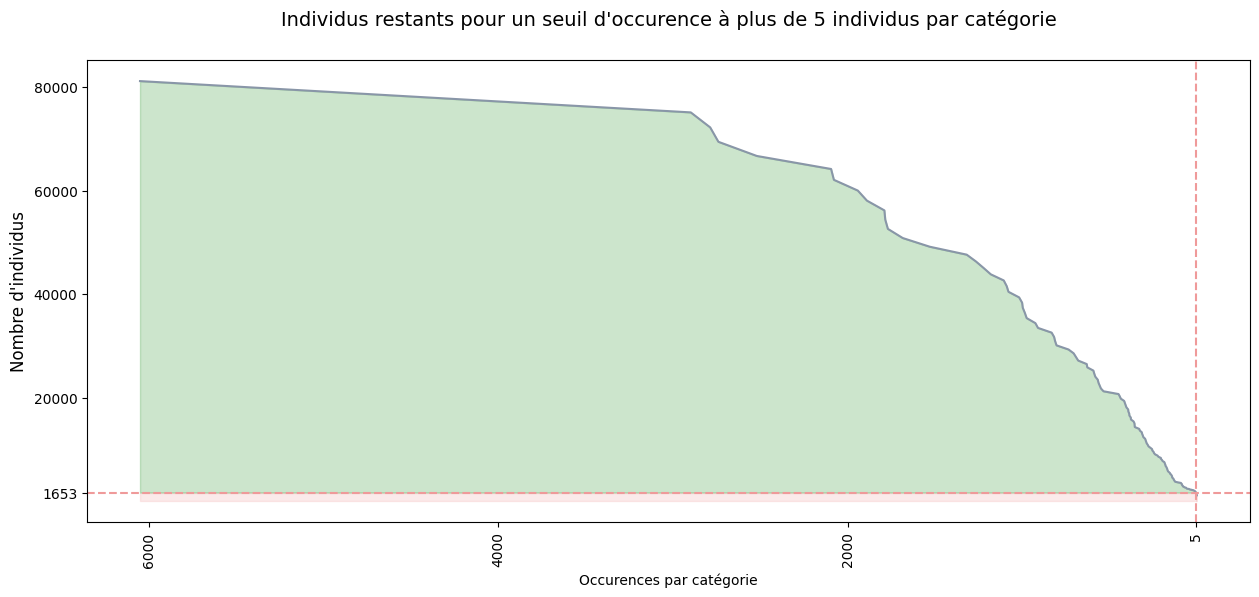

In [44]:
LimiteOccurence_graph=LimiteOccurence=5 # limite au dessus de laquelle on garde les categories
Filtre=DistribCateg[DistribCateg['Occurences']<=LimiteOccurence].sum()
Reste=DistribCateg[DistribCateg['Occurences']>LimiteOccurence].sum()
Categ2keep=ValuesCateg.loc[ValuesCateg['Occurences']>LimiteOccurence].index
print('seuil du filtre : ',LimiteOccurence)
print('nombre de catégories filtrées : ',Filtre['Nombre'],'nombre d\'individus filtrées : ',Filtre['Valeur'])
print('nombre de catégories restantes : ',Reste['Nombre'],'nombre d\'individus restants : ',Reste['Valeur'])#marge=nombrepays/170 # calcul du decalage pour inscrire la valeur dans la barre
Data=DistribCateg
plt.figure(figsize=(15, 6))
axe=sns.lineplot(data=Data, y='SommeCum', x='Occurences', color='#8996A8')
#axe=sns.lineplot(data=Data, y='SommeCum', x='Categ', color='#8996A8')
sns.set_theme(style="darkgrid")
plt.ylabel('Nombre d\'individus', fontsize=12)
plt.xlabel('Occurences par catégorie')
plt.yticks(fontsize=10)
plt.xticks(rotation=90,fontsize=10)
plt.yticks([20000, 40000, 60000, 80000, Filtre['Valeur']])
plt.xticks([2000, 4000, 6000, LimiteOccurence])
plt.title("Individus restants pour un seuil d\'occurence à plus de "+str(LimiteOccurence)+" individus par catégorie", fontsize=14, pad=25)
axe.invert_xaxis()
axe.axhline(Filtre['Valeur'], ls='--',color='#EF9A9A')
axe.axvline(LimiteOccurence, ls='--',color='#EF9A9A')
X1, Y1 = axe.lines[0].get_data()
axe.fill_between(X1, Y1, 0, where=(Y1 < Filtre['Valeur']), color='#EF9A9A', alpha=.2)
axe.fill_between([LimiteOccurence,DistribCateg['Occurences'].max()], [0,0], [Filtre['Valeur'],Filtre['Valeur']], color='#EF9A9A', alpha=.2)
axe.fill_between(X1, Y1, Filtre['Valeur'], where=(Y1 > Filtre['Valeur']), color='green', alpha=.2)
plt.show()

> Ne garder que les catégories avec plus de 5 individus permet de reduire fortement ne nombre de celles-ci avec une perte limitée d'individus

## Distribution des catégories

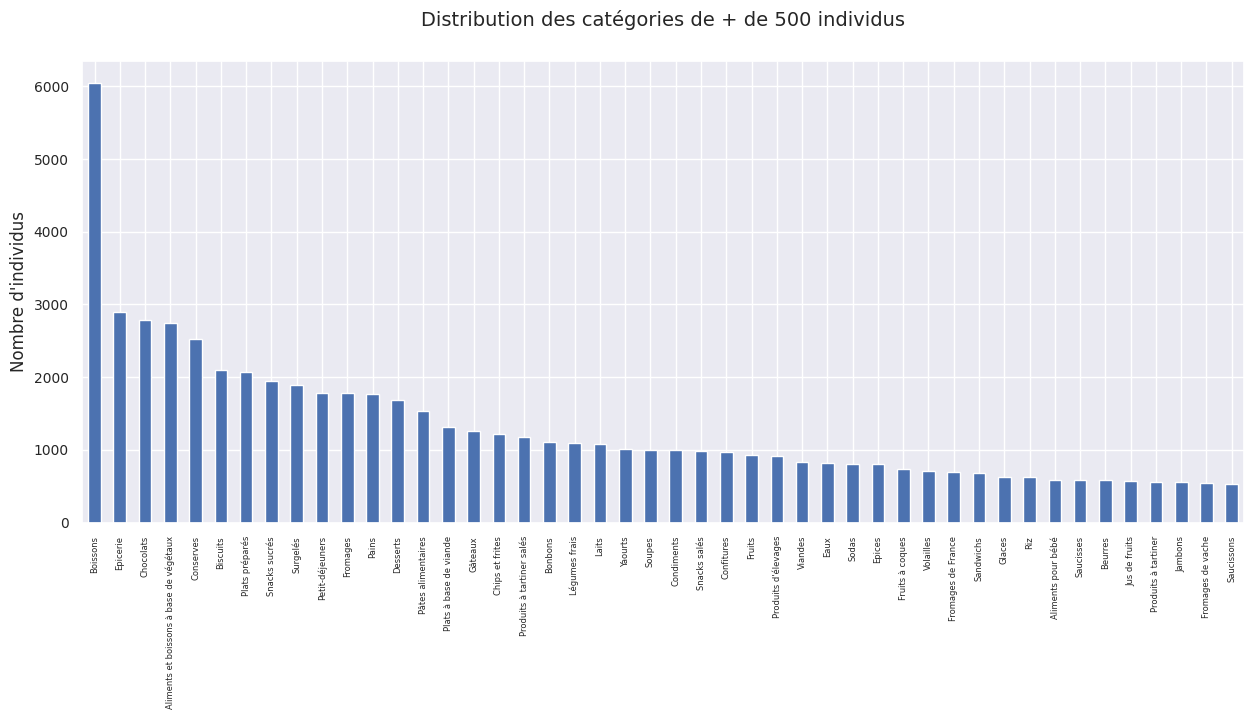

In [45]:
if LimiteOccurence_graph < 29:
    LimiteOccurence_graph = 6000
LimiteOccurence_graph = 500

plt.figure(figsize=(15, 6))
DistribValuesCateg=ValuesCateg['Occurences'].loc[ValuesCateg['Occurences']>LimiteOccurence_graph]
DistribValuesCateg.plot(kind='bar')
plt.title("Distribution des catégories de + de "+str(LimiteOccurence_graph)+" individus", fontsize=14, pad=25)
plt.ylabel('Nombre d\'individus', fontsize=12)
plt.xlabel('')
plt.yticks(fontsize=10)
plt.xticks(rotation=90,fontsize=6)
plt.show()

In [46]:
# index des produits a utiliser pour nos futurs tests
dfSpecsFr['MainFr2Study']=dfSpecsFr['main_category_fr'].isin(Categ2keep)
dfSpecsFr['MainFr2Study'].value_counts()

MainFr2Study
False    235783
True      79532
Name: count, dtype: int64

In [47]:
dfSpecsFr[dfSpecsFr['main_category_fr'].notnull()]

,categories_fr,countries_fr,additives_fr,nutrition_grade_fr,states_fr,main_category_fr,MainFr2Study
174,"Aliments et boissons à base de végétaux,Alimen...",Canada,NaN,c,"A vérifier,Complet,Informations nutritionnelle...",Légumes frais,True
175,"Snacks sucrés,Biscuits et gâteaux,Pâtisseries",Canada,"E170 - Carbonate de calcium,E300 - Acide ascor...",NaN,"A vérifier,Complet,Informations nutritionnelle...",Pâtisseries,True
177,"Aliments et boissons à base de végétaux,Alimen...",Royaume-Uni,NaN,NaN,"A compléter,Informations nutritionnelles compl...",Pains,True
180,"Snacks sucrés,Biscuits et gâteaux,Pâtisseries",Canada,"E920 - L-Cystéine et ses chlorhydrates,E330 - ...",c,"A vérifier,Complet,Informations nutritionnelle...",Pâtisseries,True
181,Boulange,Canada,NaN,b,"A vérifier,Complet,Informations nutritionnelle...",Boulange,False
...,...,...,...,...,...,...,...
320738,"Boissons,Boissons alcoolisées,Vins,Vins frança...",France,NaN,NaN,"A compléter,Informations nutritionnelles compl...",Boissons,True
320740,"Aliments et boissons à base de végétaux,Boisso...",France,NaN,c,"A vérifier,Complet,Informations nutritionnelle...",Thés verts,True
320742,"Viandes,Produits à tartiner,Charcuteries,Produ...",France,NaN,NaN,"A vérifier,Complet,Informations nutritionnelle...",Produits à tartiner salés,True
320743,"Aliments et boissons à base de végétaux,Alimen...",Royaume-Uni,NaN,NaN,"A compléter,Informations nutritionnelles à com...",Fruits à coques,True


## Sauvegarde des DataFrames

In [48]:
# Sauvegarde des Df
dfGeneral.to_csv(dossierExport+'/dfGeneral.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfNutriments.to_csv(dossierExport+'/dfNutriments.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfSpecsFr.to_csv(dossierExport+'/dfSpecsFr.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfTags.to_csv(dossierExport+'/dfTags.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfEnergy.to_csv(dossierExport+'/dfEnergy.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')

# Etape 3 - Identifier et traiter valeurs manquantes

In [49]:
# definition variables
dossierImport=dossierData+'/Etape2'
dossierExport=dossierData+'/Etape3'

# on cree le repertoire Data si il n'existe pas
CreationDir(dossierExport)

## Visualisation des valeurs manquantes dfSpecsFr

<Axes: >

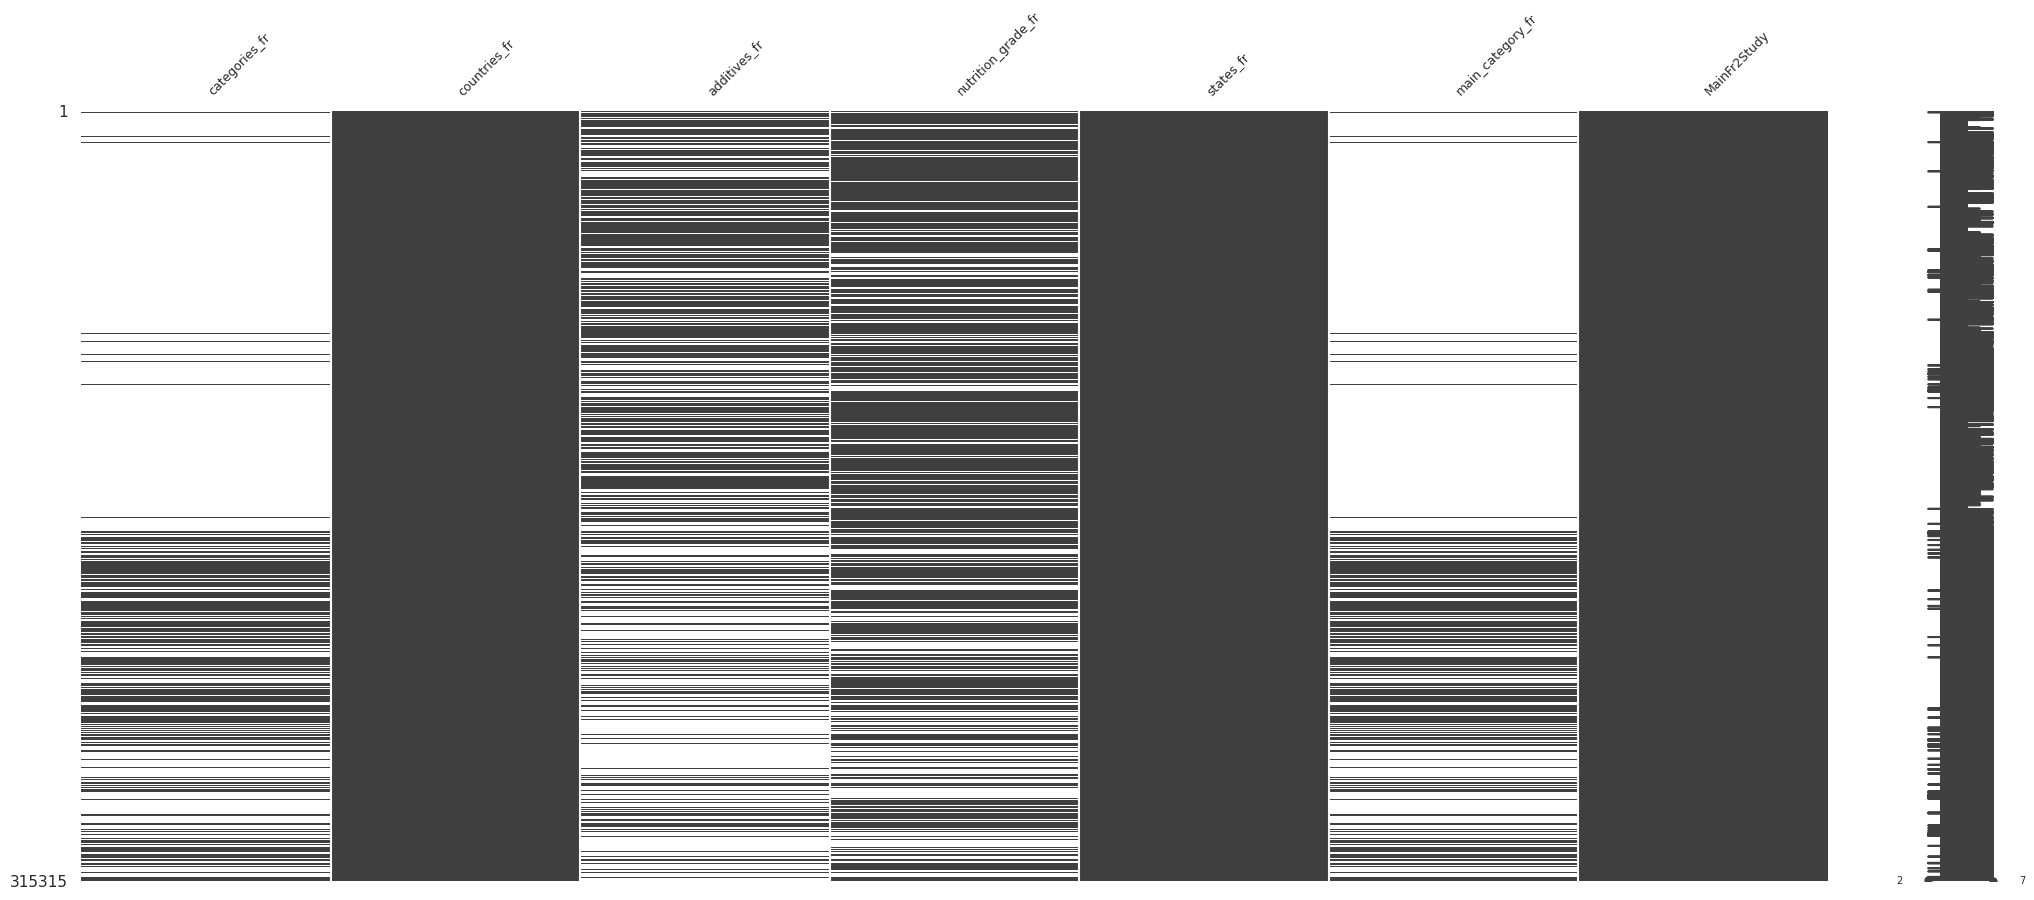

In [50]:
%matplotlib inline
filtered_data = msno.nullity_filter(dfSpecsFr, filter='top', n=50) # or filter='top'
msno.matrix(filtered_data, fontsize=9)

> nous pouvons remarquer ici les 73% de valeurs manquantes de la feature 'Main_category_fr'

## Suppression des individus n'ayant pas assez de features Nutriments

In [51]:
Index2del=dfNutriments[dfNutriments['fat'].isna() &
    dfNutriments['saturated-fat'].isna() &
    dfNutriments['carbohydrates'].isna() &
    dfNutriments['sugars'].isna() &
    dfNutriments['sodium'].isna() &
    dfNutriments['proteins'].isna()].index
print('Individus disposant de trop peu de features : ',len(Index2del))

Datas=[dfGeneral,dfNutriments,dfSpecsFr,dfTags,dfEnergy]
PurgeGeneraleDonnees(Datas,Index2del)

Individus disposant de trop peu de features :  57319
------------------ Purge Générale des Données ------------------

-- suppression de  57319  indexes du DataFrame  dfGeneral

-- nom du DataFrame analysé : dfGeneral
nombre d'individus : 257996
nombre variables : 19

-- suppression de  57319  indexes du DataFrame  dfNutriments

-- nom du DataFrame analysé : dfNutriments
nombre d'individus : 257996
nombre variables : 14

-- suppression de  57319  indexes du DataFrame  dfSpecsFr

-- nom du DataFrame analysé : dfSpecsFr
nombre d'individus : 257996
nombre variables : 7

-- suppression de  57319  indexes du DataFrame  dfTags

-- nom du DataFrame analysé : dfTags
nombre d'individus : 257996
nombre variables : 5

-- suppression de  57319  indexes du DataFrame  dfEnergy

-- nom du DataFrame analysé : dfEnergy
nombre d'individus : 257996
nombre variables : 5


### Imputation des valeurs Fer par des valeurs nulles

In [52]:
dfNutrimentsImputed=dfNutriments.copy()

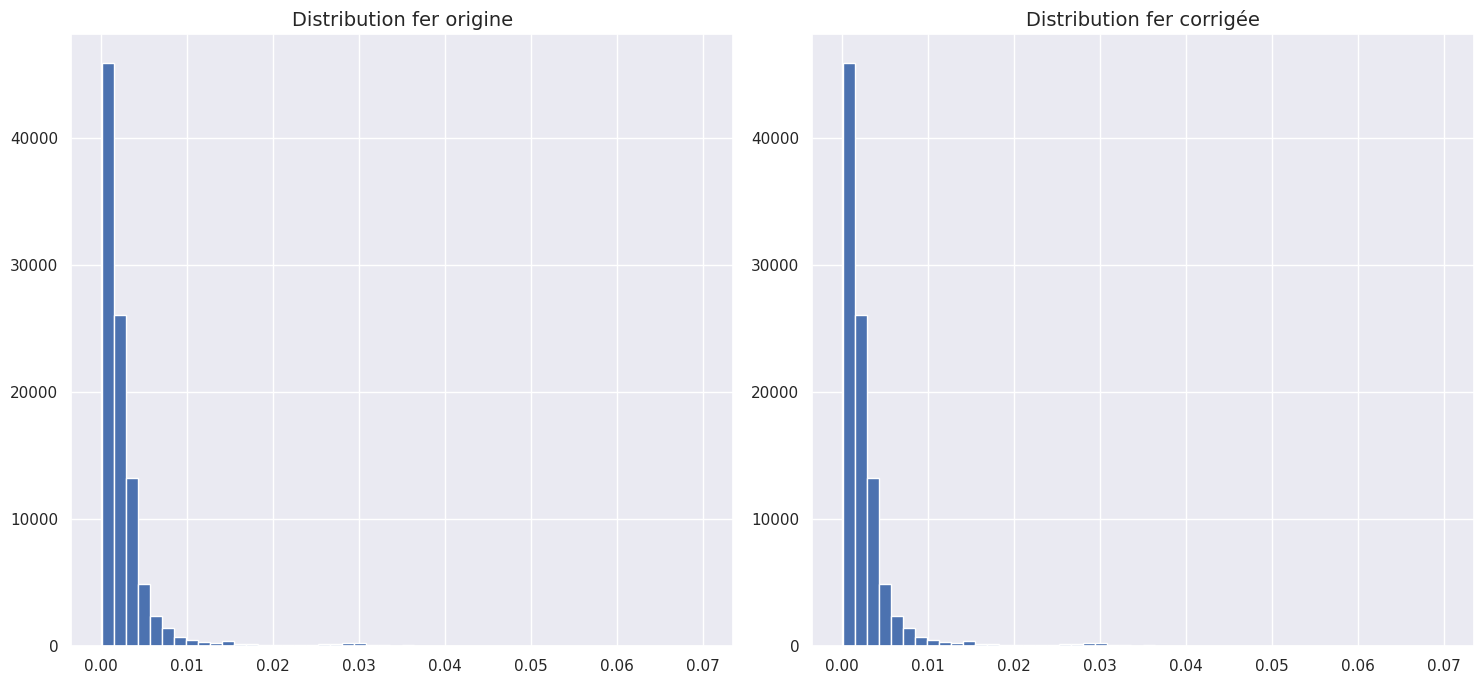

In [53]:
# il est flagrant que les usagers n'ont pas fait de saisie pour le Fer quand l'information valait 0
imputer = sklearn.impute.SimpleImputer()
imputer.set_params(keep_empty_features=True)
dfNutrimentsImputed[['iron']]=dfNutrimentsImputed[['iron']].fillna(0)

fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1,2,1)
plt.title("Distribution fer origine", fontsize=14)
hist = dfNutriments['iron'].hist(bins=50, range=(0.0001,0.07))
ax2 = fig.add_subplot(1,2,2)
plt.title("Distribution fer corrigée", fontsize=14)
hist = dfNutrimentsImputed['iron'].hist(bins=50, range=(0.0001,.07))
plt.tight_layout()

## Relation entre le Sodium et le Sel

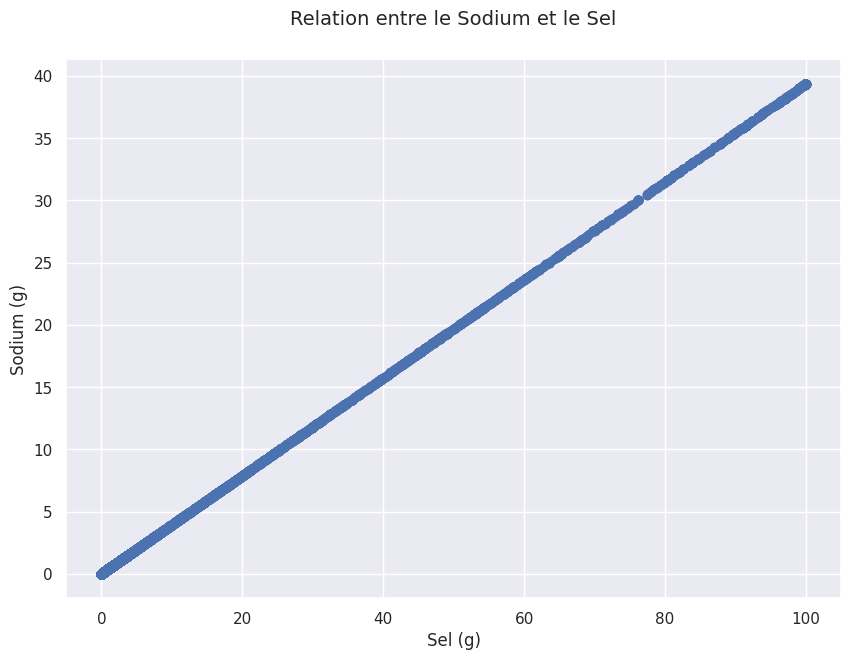

In [54]:
plt.figure(figsize = (10,7))
plt.title("Relation entre le Sodium et le Sel", fontsize=14, pad=25)
plt.rcParams.update({'font.size': 8})
plt.xlabel("Sel (g)")
plt.ylabel("Sodium (g)")
plt.scatter(dfNutriments['salt'],dfNutriments['sodium'])

> La relation entre le sel et le sodium est linéaire

In [55]:
# le sel étant en corrélation directe avec le sodium celui-ci n'est pas nécessaire
if 'salt' in dfNutrimentsImputed.columns:
    dfNutrimentsImputed=dfNutrimentsImputed.drop('salt',axis=1)

## Visualisation nutriments manquants

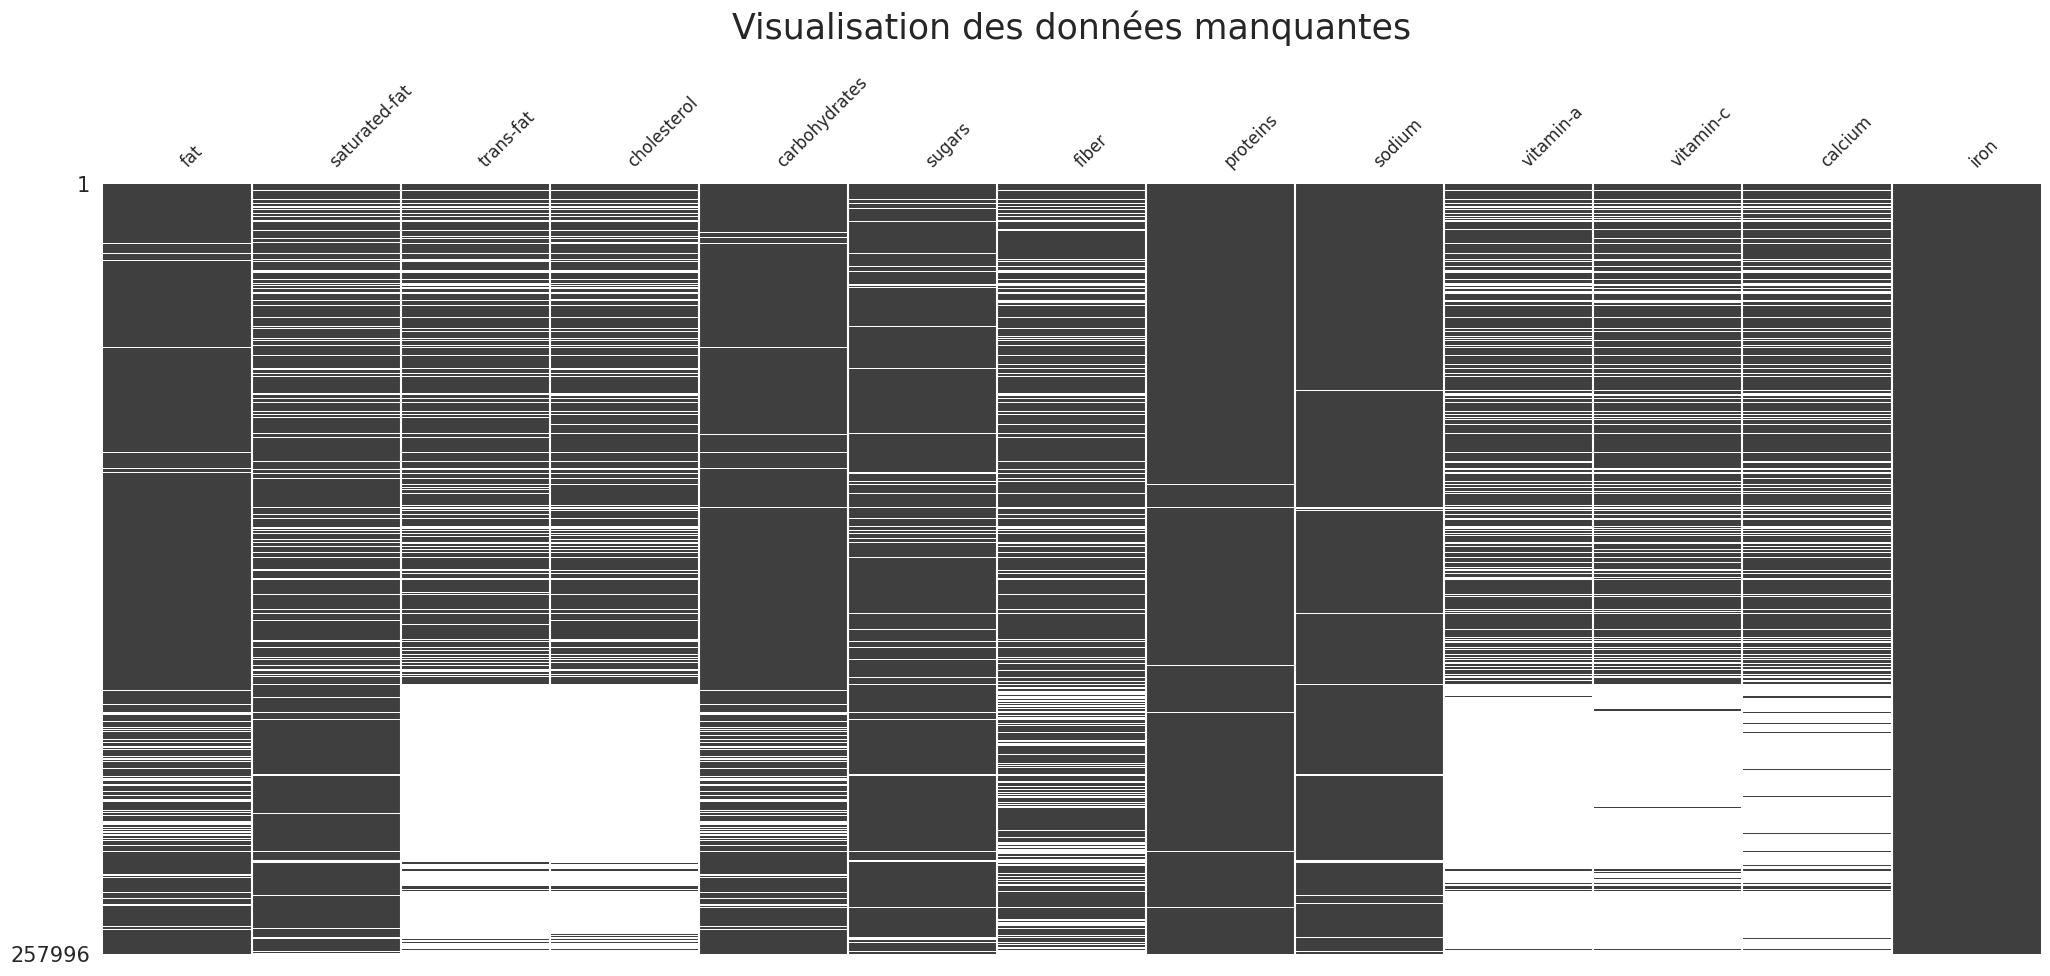

In [56]:
msno.matrix(dfNutrimentsImputed, fontsize=12, sparkline=False)
plt.title("Visualisation des données manquantes", fontsize=25, pad=25)
plt.show()

> Les valeurs des acides gras, cholestérol, vitamines, calcium semblent s’arrêter toutes simultanément nous allons donc les ignorer vu le peu d’intérêt pour notre étude.


In [57]:
# on supprime les colonnes non necessaires
if 'trans-fat' in dfNutrimentsImputed.columns:
    dfNutrimentsImputed=dfNutrimentsImputed.drop('trans-fat',axis=1)
if 'cholesterol' in dfNutrimentsImputed.columns:
    dfNutrimentsImputed=dfNutrimentsImputed.drop('cholesterol',axis=1)
if 'calcium' in dfNutrimentsImputed.columns:
    dfNutrimentsImputed=dfNutrimentsImputed.drop('calcium',axis=1)
if 'vitamin-a' in dfNutrimentsImputed.columns:
    dfNutrimentsImputed=dfNutrimentsImputed.drop('vitamin-a',axis=1)
if 'vitamin-c' in dfNutrimentsImputed.columns:
    dfNutrimentsImputed=dfNutrimentsImputed.drop('vitamin-c',axis=1)

## Nouvelle visualisation des valeurs manquantes Nutriments

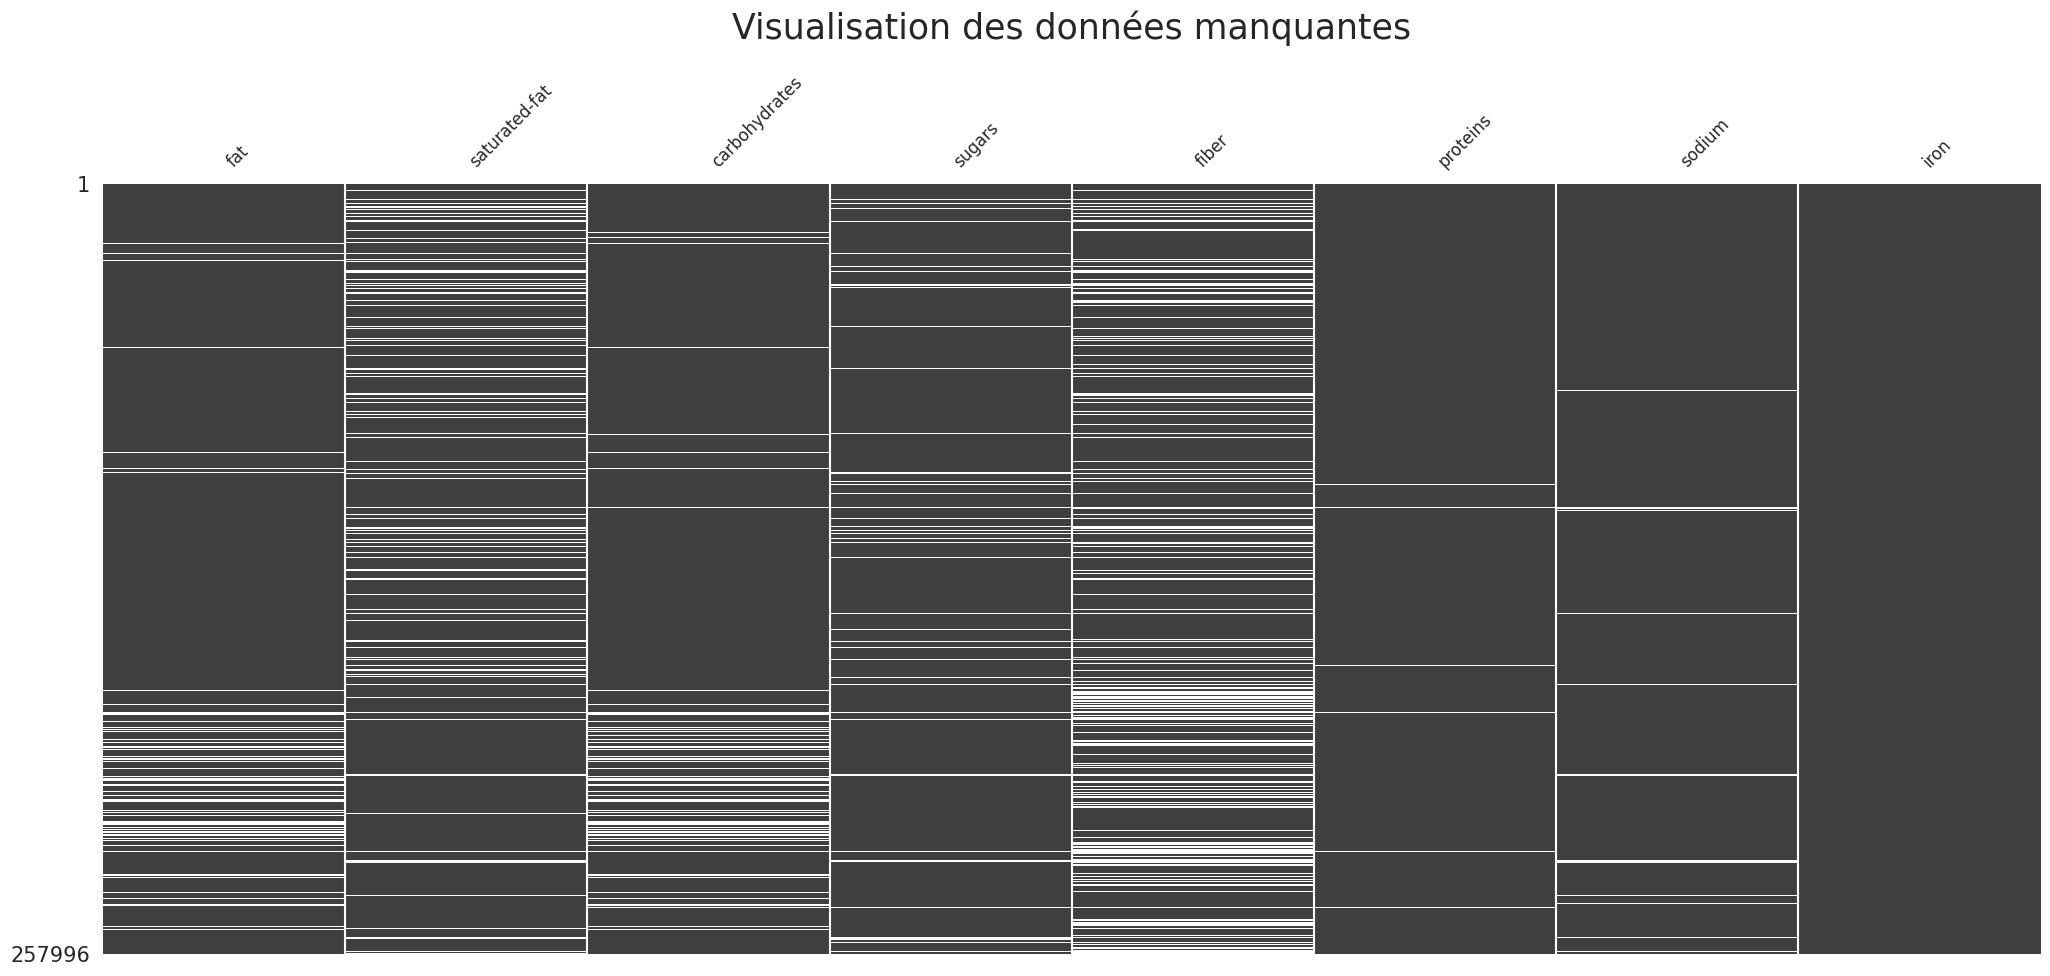

In [58]:
msno.matrix(dfNutrimentsImputed, fontsize=12, sparkline=False)
plt.title("Visualisation des données manquantes", fontsize=25, pad=25)
plt.show()

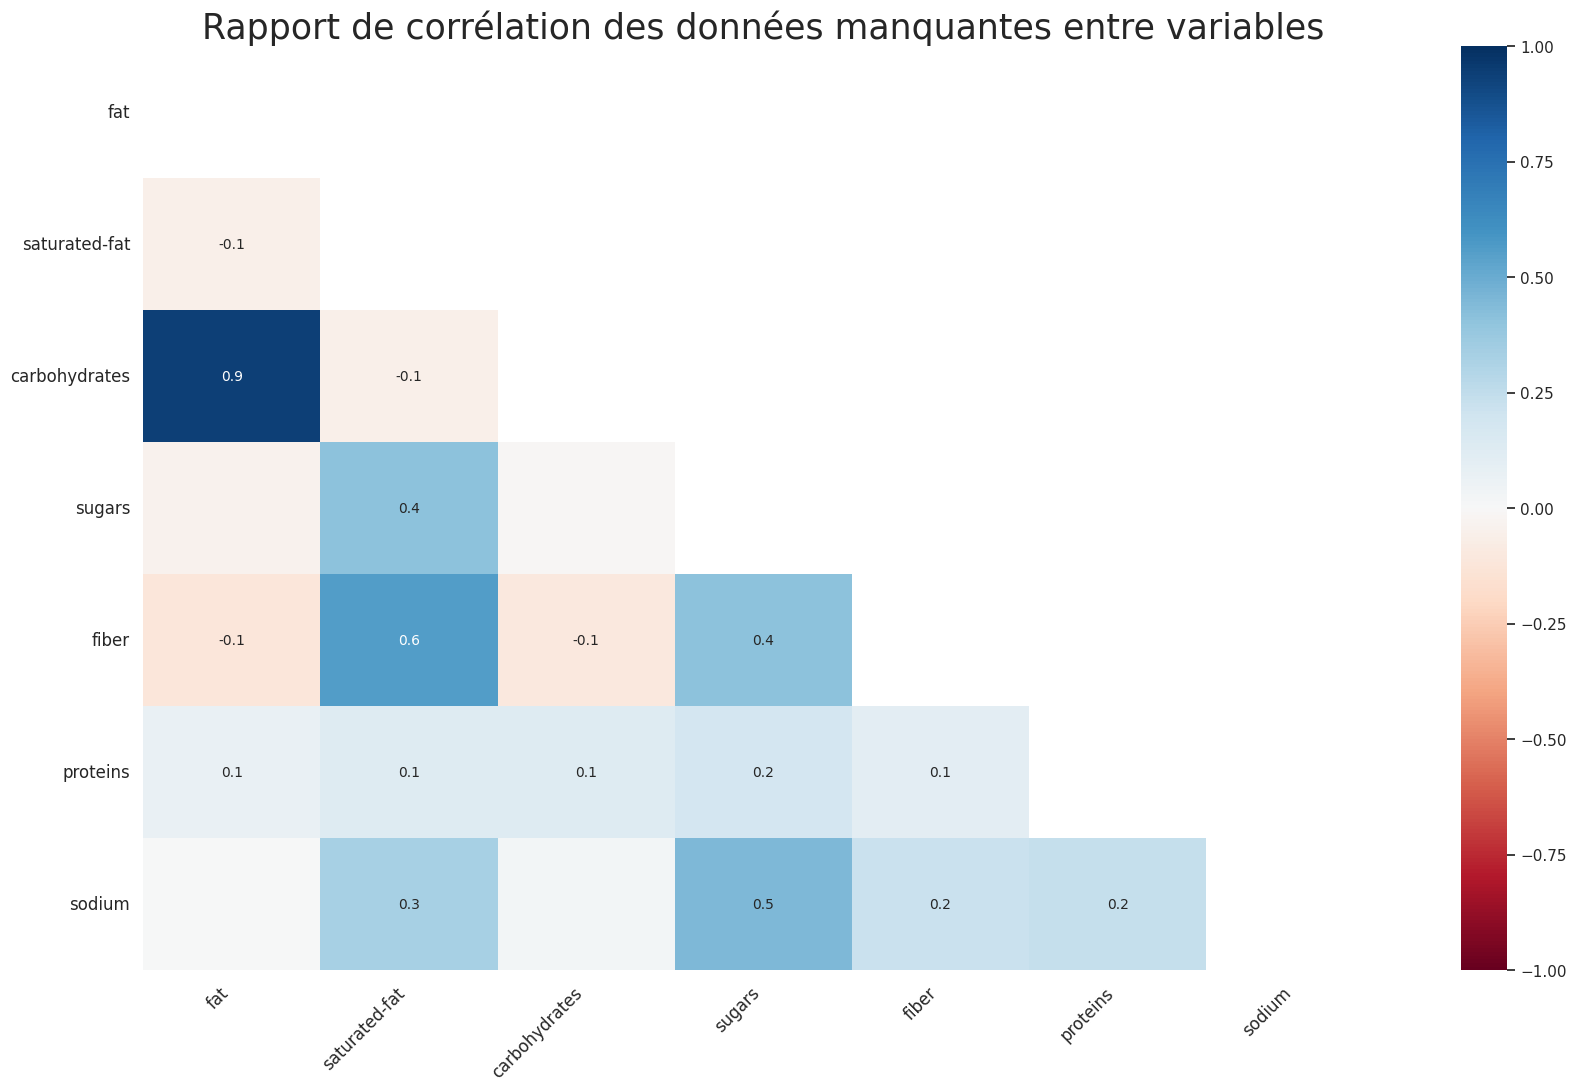

In [59]:
msno.heatmap(dfNutrimentsImputed, fontsize=12)
plt.title("Rapport de corrélation des données manquantes entre variables", fontsize=25)
plt.show()

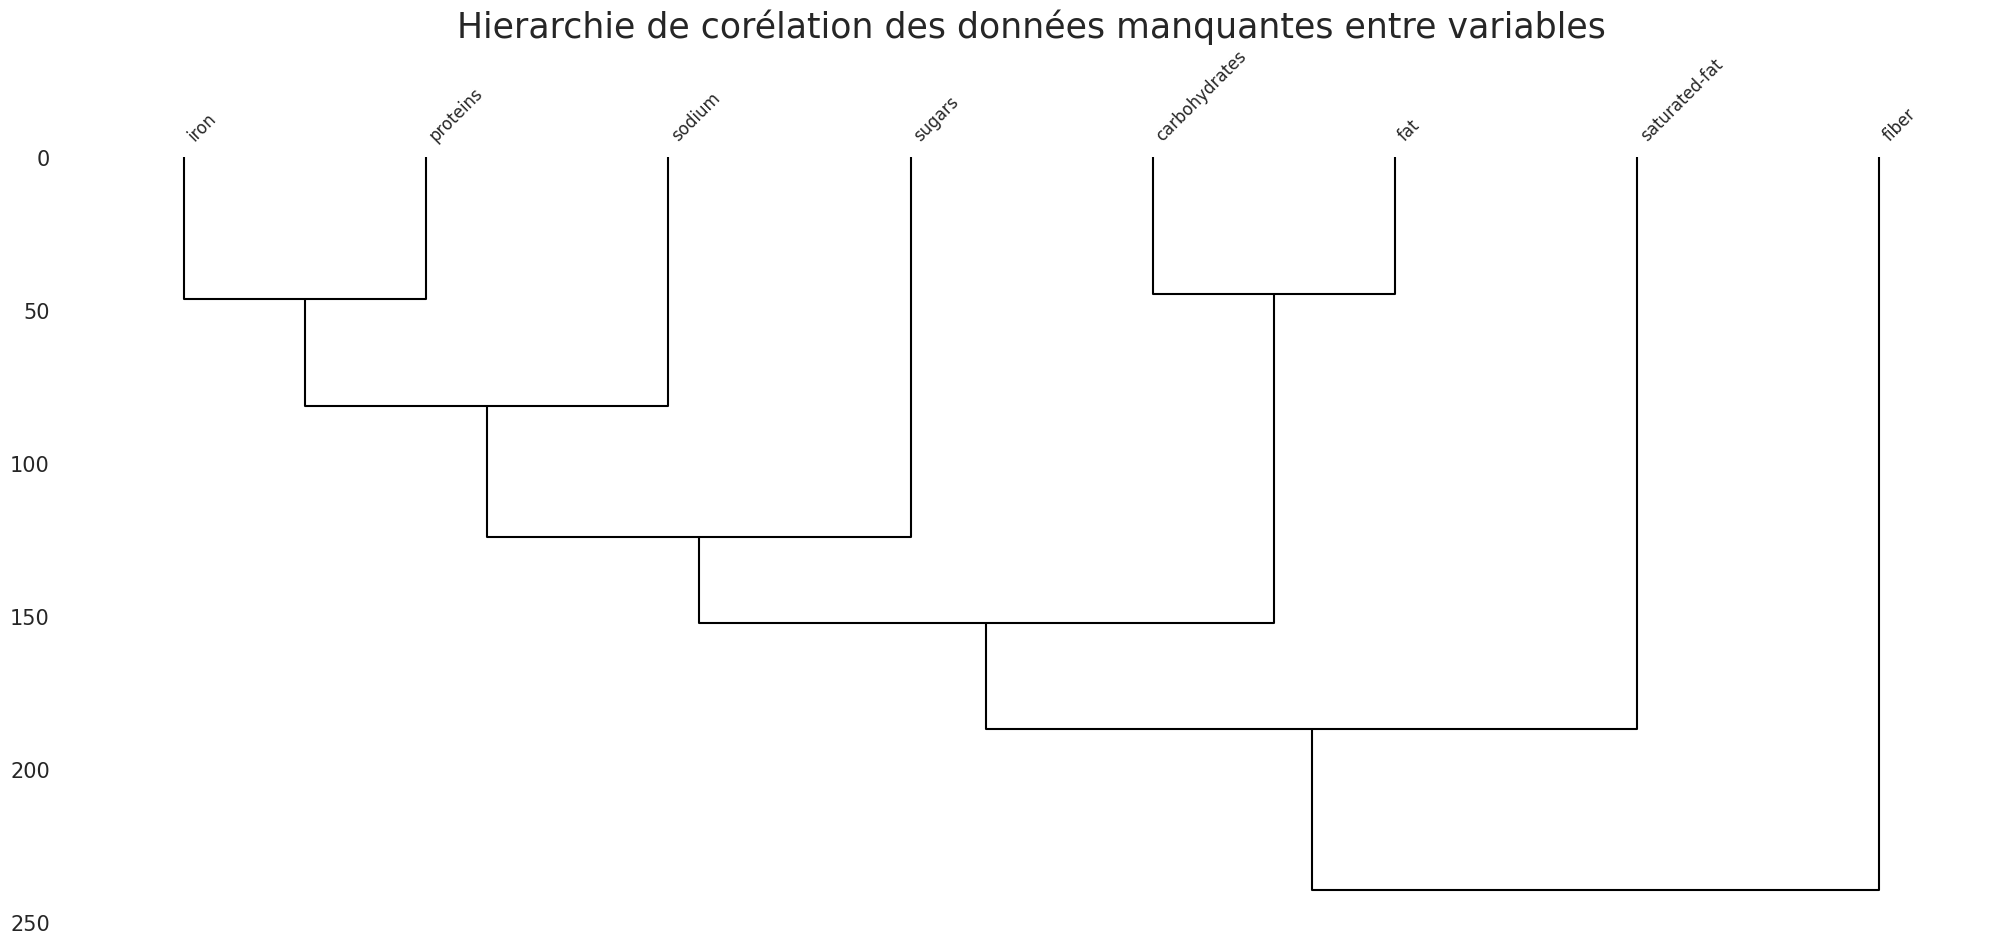

In [60]:
msno.dendrogram(dfNutrimentsImputed, fontsize=12)
plt.title("Hierarchie de corélation des données manquantes entre variables", fontsize=25)
plt.show()

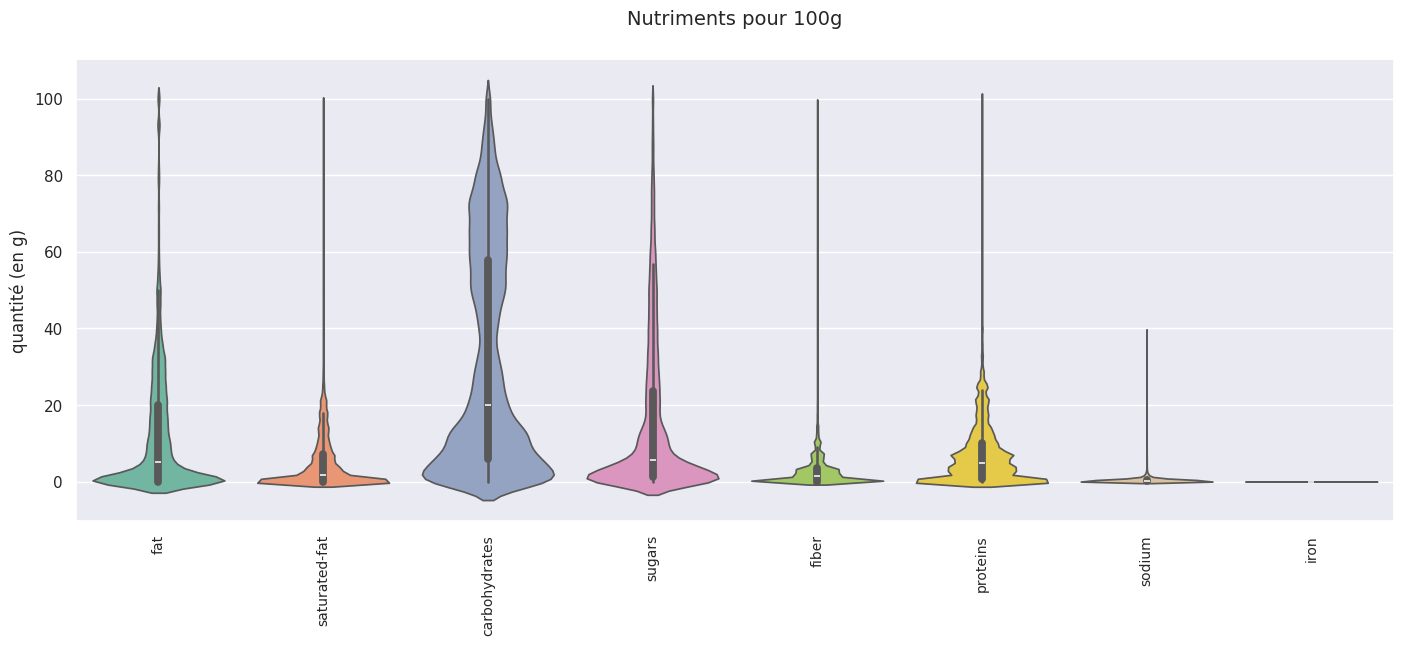

In [61]:
# Création des violinplots
plt.figure(figsize=(17, 6))
sns.violinplot(data = dfNutrimentsImputed, palette="Set2", legend=False)
plt.title("Nutriments pour 100g", fontsize=14, pad=25)
plt.xticks(rotation=90,fontsize=10)
plt.ylabel("quantité (en g)", fontsize=12)
plt.show()

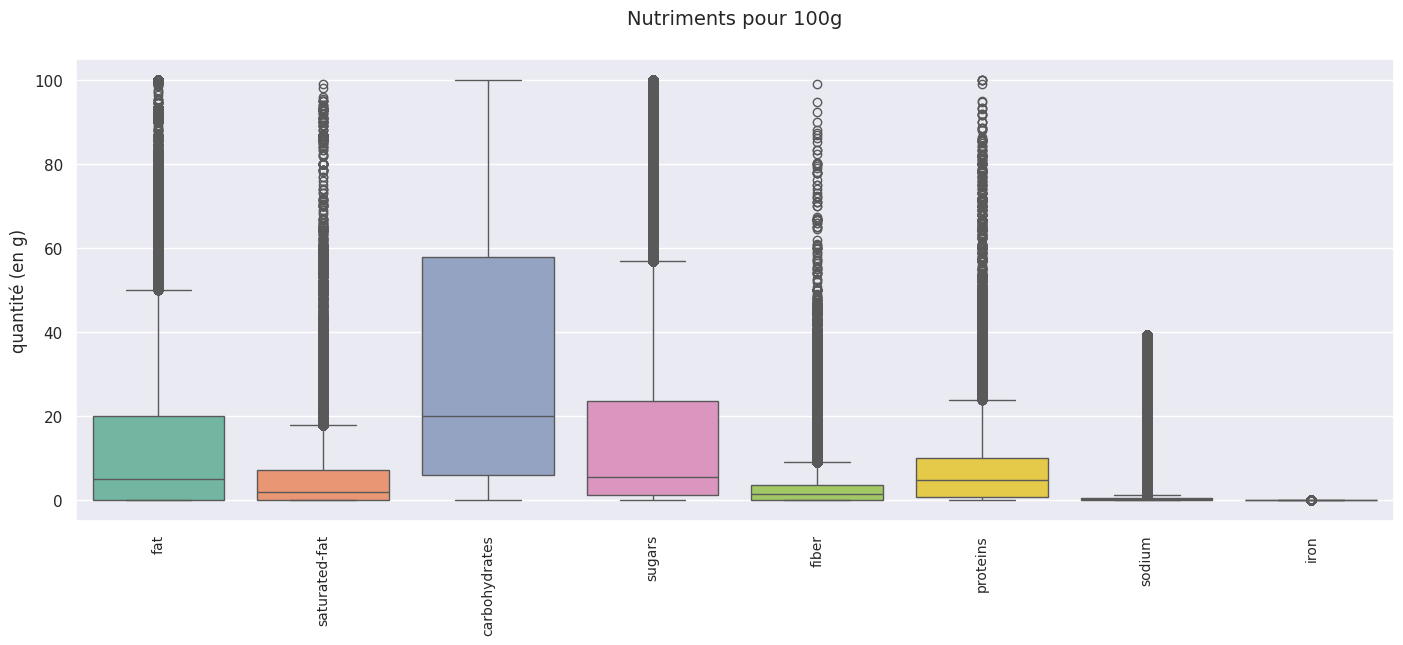

In [62]:
# Création des boxplots
plt.figure(figsize=(17,6))
sns.set_theme(style="darkgrid")
sns.boxplot(data = dfNutrimentsImputed, palette="Set2", legend=False)
plt.title("Nutriments pour 100g", fontsize=14, pad=25)
plt.xticks(rotation=90,fontsize=10)
plt.ylabel("quantité (en g)", fontsize=12)
plt.show()


> Les valeurs extrèmes sont justifiées, pour information Sodium 39g et Fer 70Mg en valeur max

In [63]:
dfNutrimentsImputed.describe()

,fat,saturated-fat,carbohydrates,sugars,fiber,proteins,sodium,iron
count,239877.000000,226580.000000,239584.000000,241337.000000,198615.000000,255825.000000,251502.000000,257996.000000
mean,12.731381,5.120935,31.662341,15.644408,2.831346,7.115803,0.621068,0.000997
std,17.363892,7.847094,28.719274,20.574463,4.514411,8.135428,2.429424,0.002698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,5.980000,1.300000,0.000000,0.710000,0.025000,0.000000
50%,5.100000,1.800000,20.000000,5.600000,1.500000,4.800000,0.232000,0.000000
75%,20.000000,7.140000,57.780000,23.530000,3.600000,10.000000,0.543000,0.001200
max,100.000000,99.000000,100.000000,100.000000,99.000000,100.000000,39.370079,0.069230


### Imputation par KNN des valeurs manquantes de Graisses, Graisses saturées, Sucres, Protéines, Glucides, Sodium, Fibres

In [64]:
dfImputer=dfNutrimentsImputed[['fat','saturated-fat','sugars','proteins','carbohydrates','sodium','fiber']]
dfImputer=dfImputer.join(dfEnergy[['energy','nutrition-score-fr']], on=None, how='left', sort=False, validate=None)
dfNutriments=dfNutriments.join(dfEnergy[['energy','nutrition-score-fr']], on=None, how='left', sort=False, validate=None)

In [65]:
X_train=dfImputer.loc[((~dfImputer['fat'].isna()) &
                    (~dfImputer['saturated-fat'].isna()) &
                    (~dfImputer['sugars'].isna()) &
                    (~dfImputer['proteins'].isna()) &
                    (~dfImputer['carbohydrates'].isna()) &
                    (~dfImputer['sodium'].isna()) &
                    (~dfImputer['energy'].isna()) &
                    (~dfImputer['nutrition-score-fr'].isna()) &
                    (~dfImputer['fiber'].isna()))]

X=dfImputer.loc[((~dfImputer['fat'].isna()) |
                    (~dfImputer['saturated-fat'].isna()) |
                    (~dfImputer['sugars'].isna()) |
                    (~dfImputer['proteins'].isna()) |
                    (~dfImputer['carbohydrates'].isna()) |
                    (~dfImputer['sodium'].isna()) |
                    (~dfImputer['energy'].isna()) |
                    (~dfImputer['nutrition-score-fr'].isna()) |
                    (~dfImputer['fiber'].isna()))]

In [66]:
imputer = sklearn.impute.KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(X_train)

start = time.time()
dfImputer_transorm = imputer.transform(X)
print('Temps d\'execution :',round(time.time() - start,1),' s')

dfNutriments_new=pd.DataFrame(dfImputer_transorm, columns=X.columns, index=X.index)
dfNutrimentsImputed[['fat','saturated-fat','sugars','proteins','carbohydrates','sodium','fiber','energy','nutrition-score-fr']]=dfNutriments_new[['fat','saturated-fat','sugars','proteins','carbohydrates','sodium','fiber','energy','nutrition-score-fr']]

Temps d'execution : 1137.6  s


> L'imputation par KNN dure près de 19 minutes

### Comparaison des distributions avant et après imputation

---------------------> matières grasses <---------------------
valeurs origines nan = 18119
valeurs origines nulles = 62520
valeurs imputées nan = 0
valeurs imputées nulles = 64028
---------------------> graisses saturées <---------------------
valeurs origines nan = 31416
valeurs origines nulles = 67556
valeurs imputées nan = 0
valeurs imputées nulles = 89664
---------------------> proteines <---------------------
valeurs origines nan = 2171
valeurs origines nulles = 51564
valeurs imputées nan = 0
valeurs imputées nulles = 51875
---------------------> sucres <---------------------
valeurs origines nan = 16659
valeurs origines nulles = 36491
valeurs imputées nan = 0
valeurs imputées nulles = 43920
---------------------> glucides <---------------------
valeurs origines nan = 18412
valeurs origines nulles = 21151
valeurs imputées nan = 0
valeurs imputées nulles = 21520
---------------------> sodium <---------------------
valeurs origines nan = 6494
valeurs origines nulles = 32594
valeurs

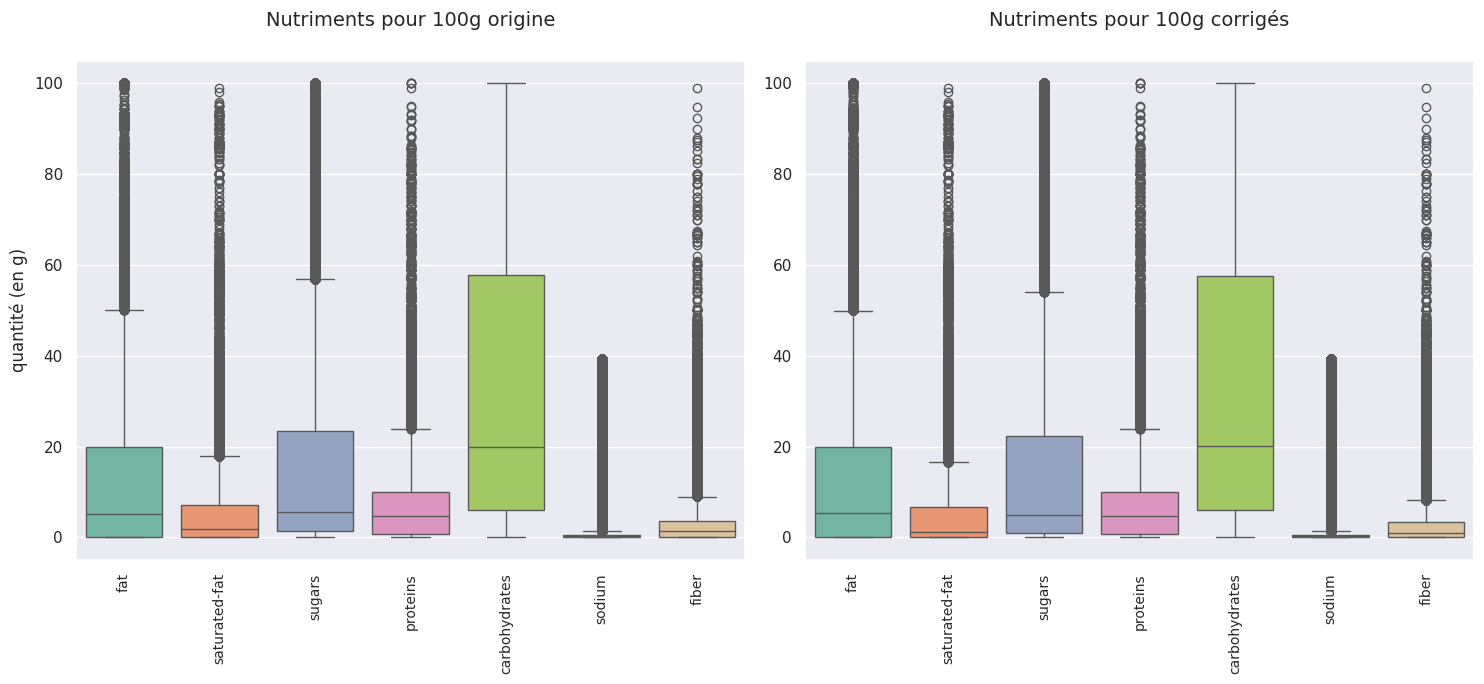

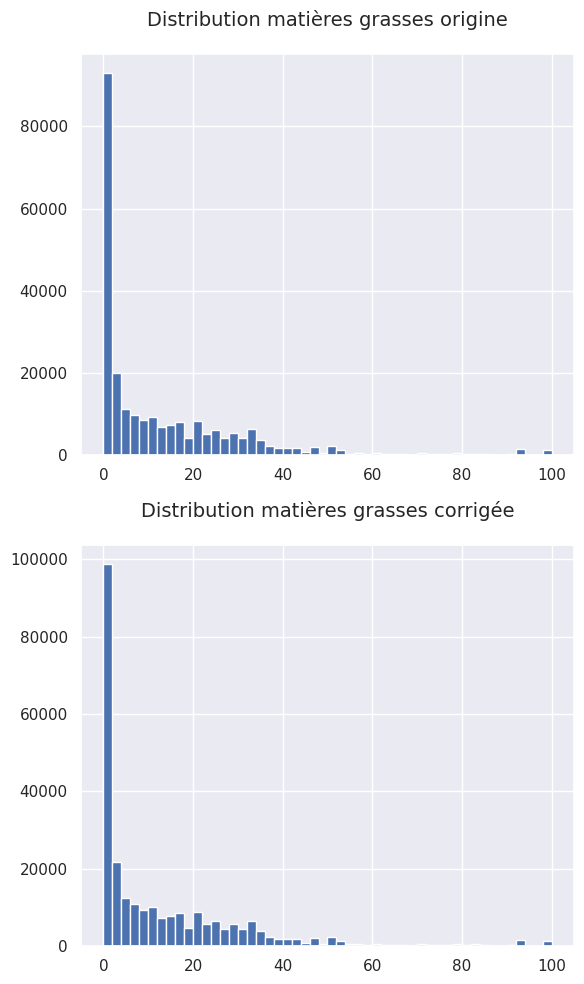

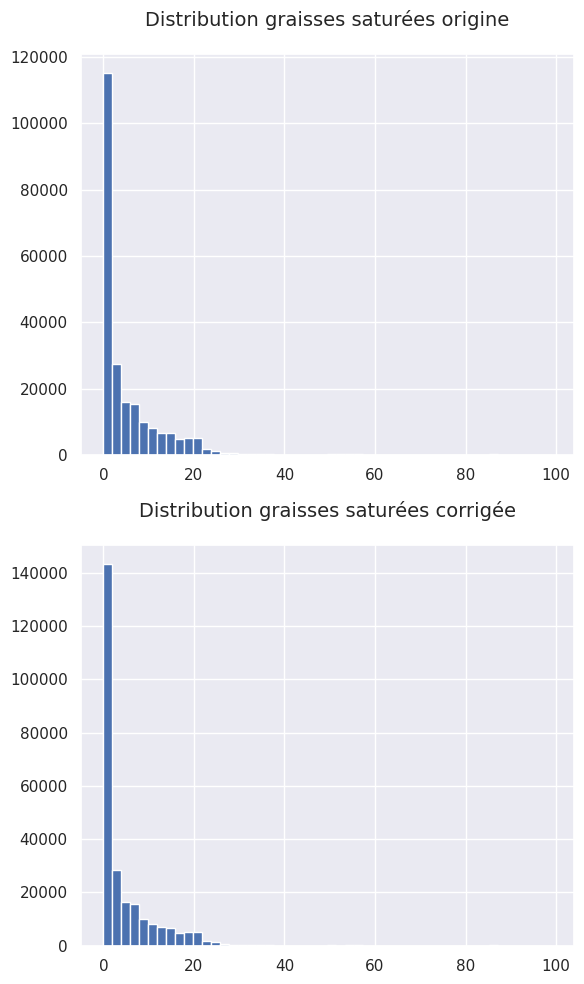

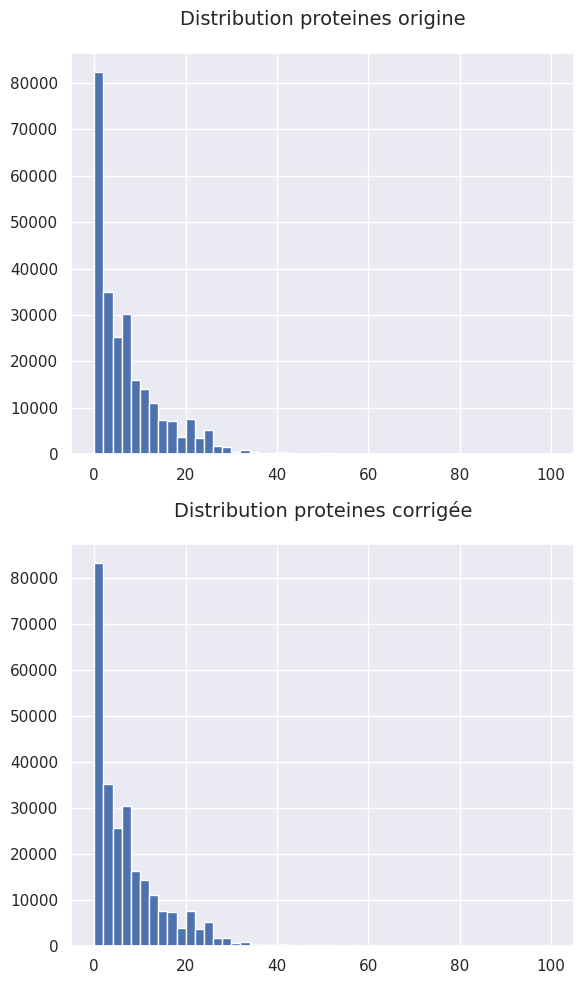

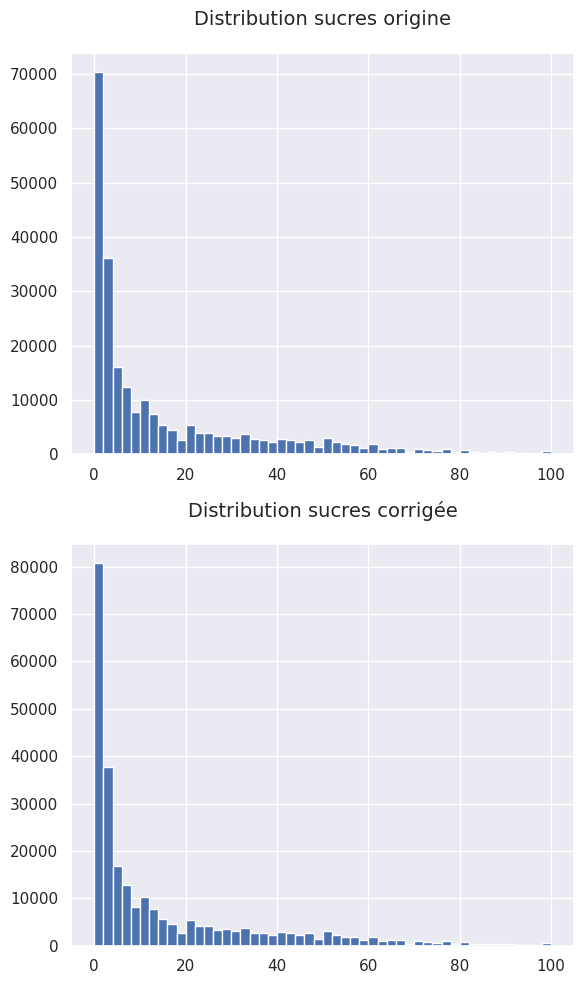

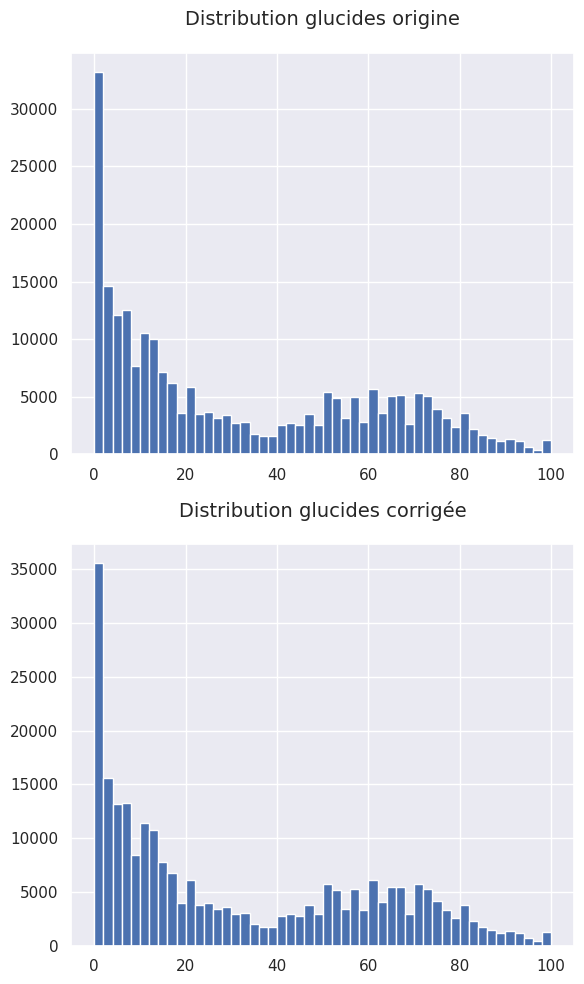

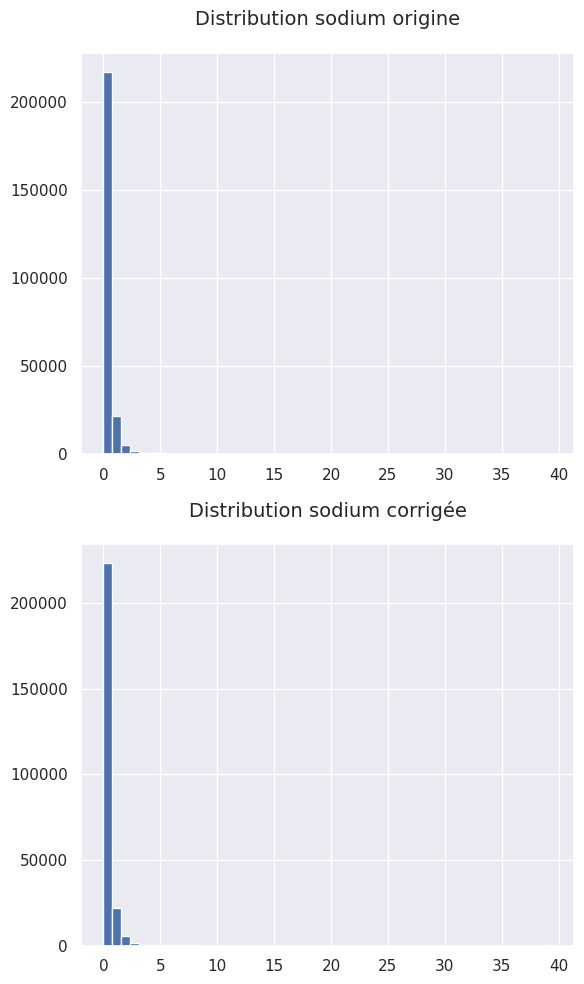

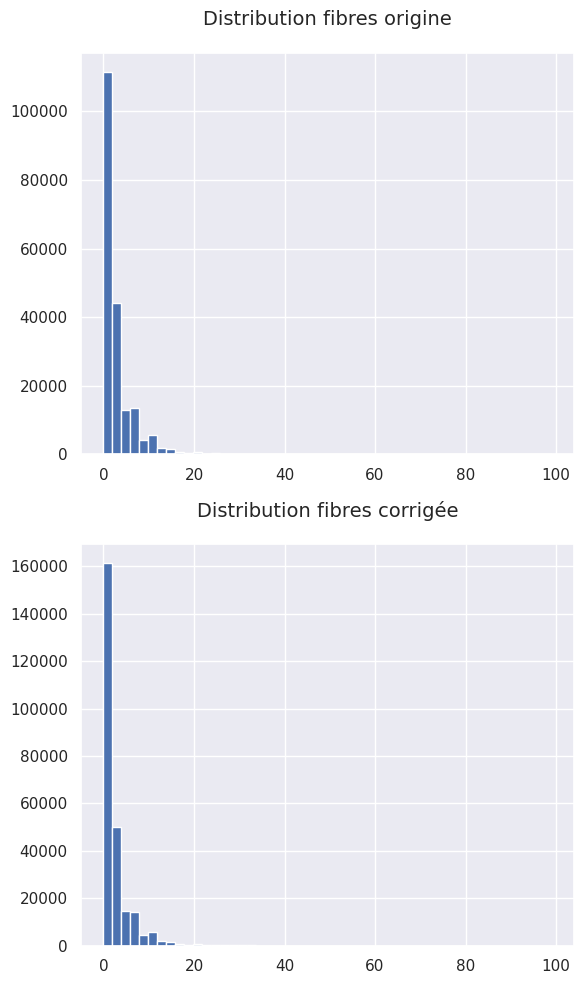

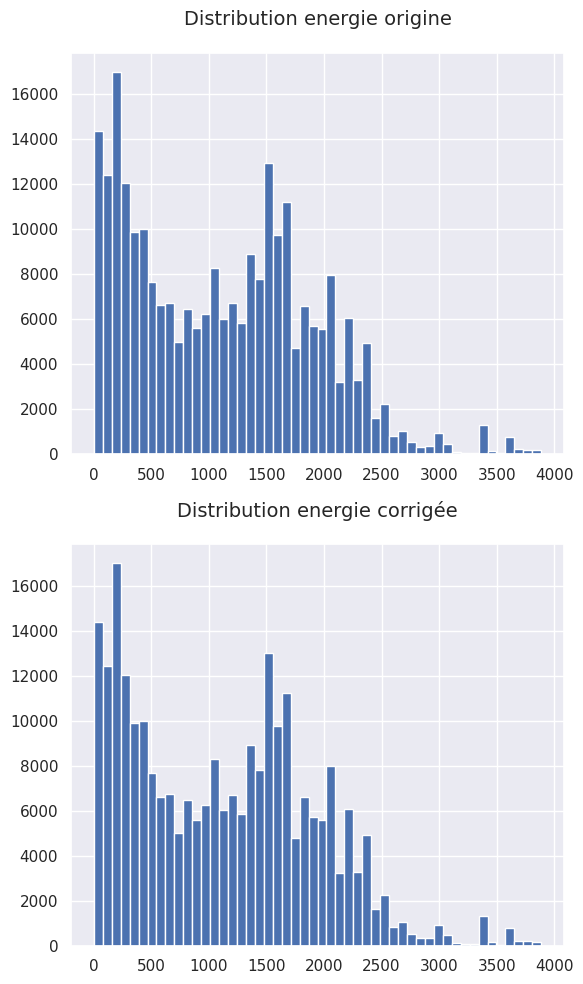

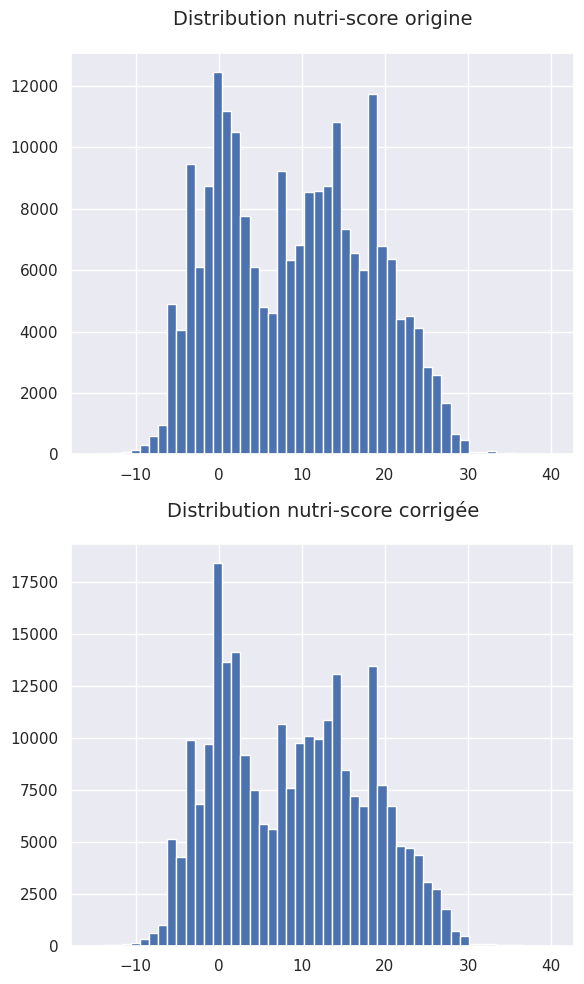

In [67]:
# boxplot
fig = plt.figure(figsize=(15,7))
sns.set_theme(style="darkgrid")
ax1 = fig.add_subplot(1,2,1)
plt.title("Nutriments pour 100g origine", fontsize=14, pad=25)
plt.xticks(rotation=90,fontsize=10)
plt.ylabel("quantité (en g)", fontsize=12)
sns.boxplot(data = dfNutriments[['fat','saturated-fat','sugars','proteins','carbohydrates','sodium','fiber']], palette="Set2", legend=False)
ax2 = fig.add_subplot(1,2,2)
plt.title("Nutriments pour 100g corrigés", fontsize=14, pad=25)
plt.xticks(rotation=90,fontsize=10)
sns.boxplot(data = dfNutrimentsImputed[['fat','saturated-fat','sugars','proteins','carbohydrates','sodium','fiber']], palette="Set2", legend=False)
plt.tight_layout()
features=[['matières grasses','fat'],['graisses saturées','saturated-fat'],['proteines','proteins'],['sucres','sugars'],['glucides','carbohydrates'],['sodium','sodium'],['fibres','fiber'],['energie','energy'],['nutri-score','nutrition-score-fr']]
for feature in features:
    print('--------------------->',feature[0],'<---------------------')
    print('valeurs origines nan =',dfNutriments[feature[1]].isna().sum())
    print('valeurs origines nulles =',(dfNutriments[feature[1]]==0).sum())
    #print(dfNutriments[feature[1]].describe())
    print('valeurs imputées nan =',dfNutrimentsImputed[feature[1]].isna().sum())
    print('valeurs imputées nulles =',(dfNutrimentsImputed[feature[1]]==0).sum())
    #print(dfNutrimentsImputed[feature[1]].describe())
    # distribution
    fig = plt.figure(figsize=(6,10))
    ax1 = fig.add_subplot(2,1,1)
    plt.title("Distribution "+feature[0]+" origine", fontsize=14, pad=20)
    hist = dfNutriments[feature[1]].hist(bins=50)
    ax2 = fig.add_subplot(2,1,2)
    plt.title("Distribution "+feature[0]+" corrigée", fontsize=14, pad=20)
    hist = dfNutrimentsImputed[feature[1]].hist(bins=50)
    plt.tight_layout()


<Axes: title={'center': 'Fer pour 100g'}, ylabel='quantité (en g)'>

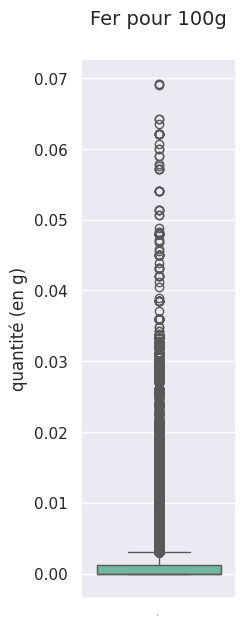

In [68]:
fig = plt.figure(figsize=(2,7))
sns.set_theme(style="darkgrid")
ax1 = fig.add_subplot()
plt.title("Fer pour 100g", fontsize=14, pad=25)
plt.xlabel("")
plt.xticks(rotation=90,fontsize=0)
plt.ylabel("quantité (en g)", fontsize=12)
sns.boxplot(data = dfNutrimentsImputed[['iron']], palette="Set2", legend=False)

> détail distribution fer pour les annexes 

In [69]:
dfNutrimentsImputed[['iron']].describe()

,iron
count,257996.000000
mean,0.000997
std,0.002698
min,0.000000
25%,0.000000
50%,0.000000
75%,0.001200
max,0.069230


<Axes: title={'center': 'Sodium pour 100g'}, ylabel='quantité (en g)'>

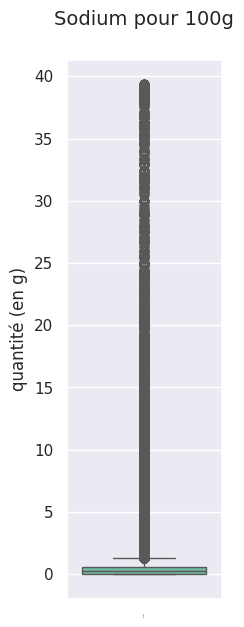

In [70]:
fig = plt.figure(figsize=(2,7))
sns.set_theme(style="darkgrid")
ax1 = fig.add_subplot()
plt.title("Sodium pour 100g", fontsize=14, pad=25)
plt.xlabel("")
plt.xticks(rotation=90,fontsize=0)
plt.ylabel("quantité (en g)", fontsize=12)
sns.boxplot(data = dfNutrimentsImputed[['sodium']], palette="Set2", legend=False)

> détail distribution sodium pour les annexes 

In [71]:
dfNutrimentsImputed[['sodium']].describe()

,sodium
count,257996.000000
mean,0.616930
std,2.405189
min,0.000000
25%,0.027000
50%,0.232283
75%,0.540000
max,39.370079


## Visualisation des valeurs manquantes après imputation

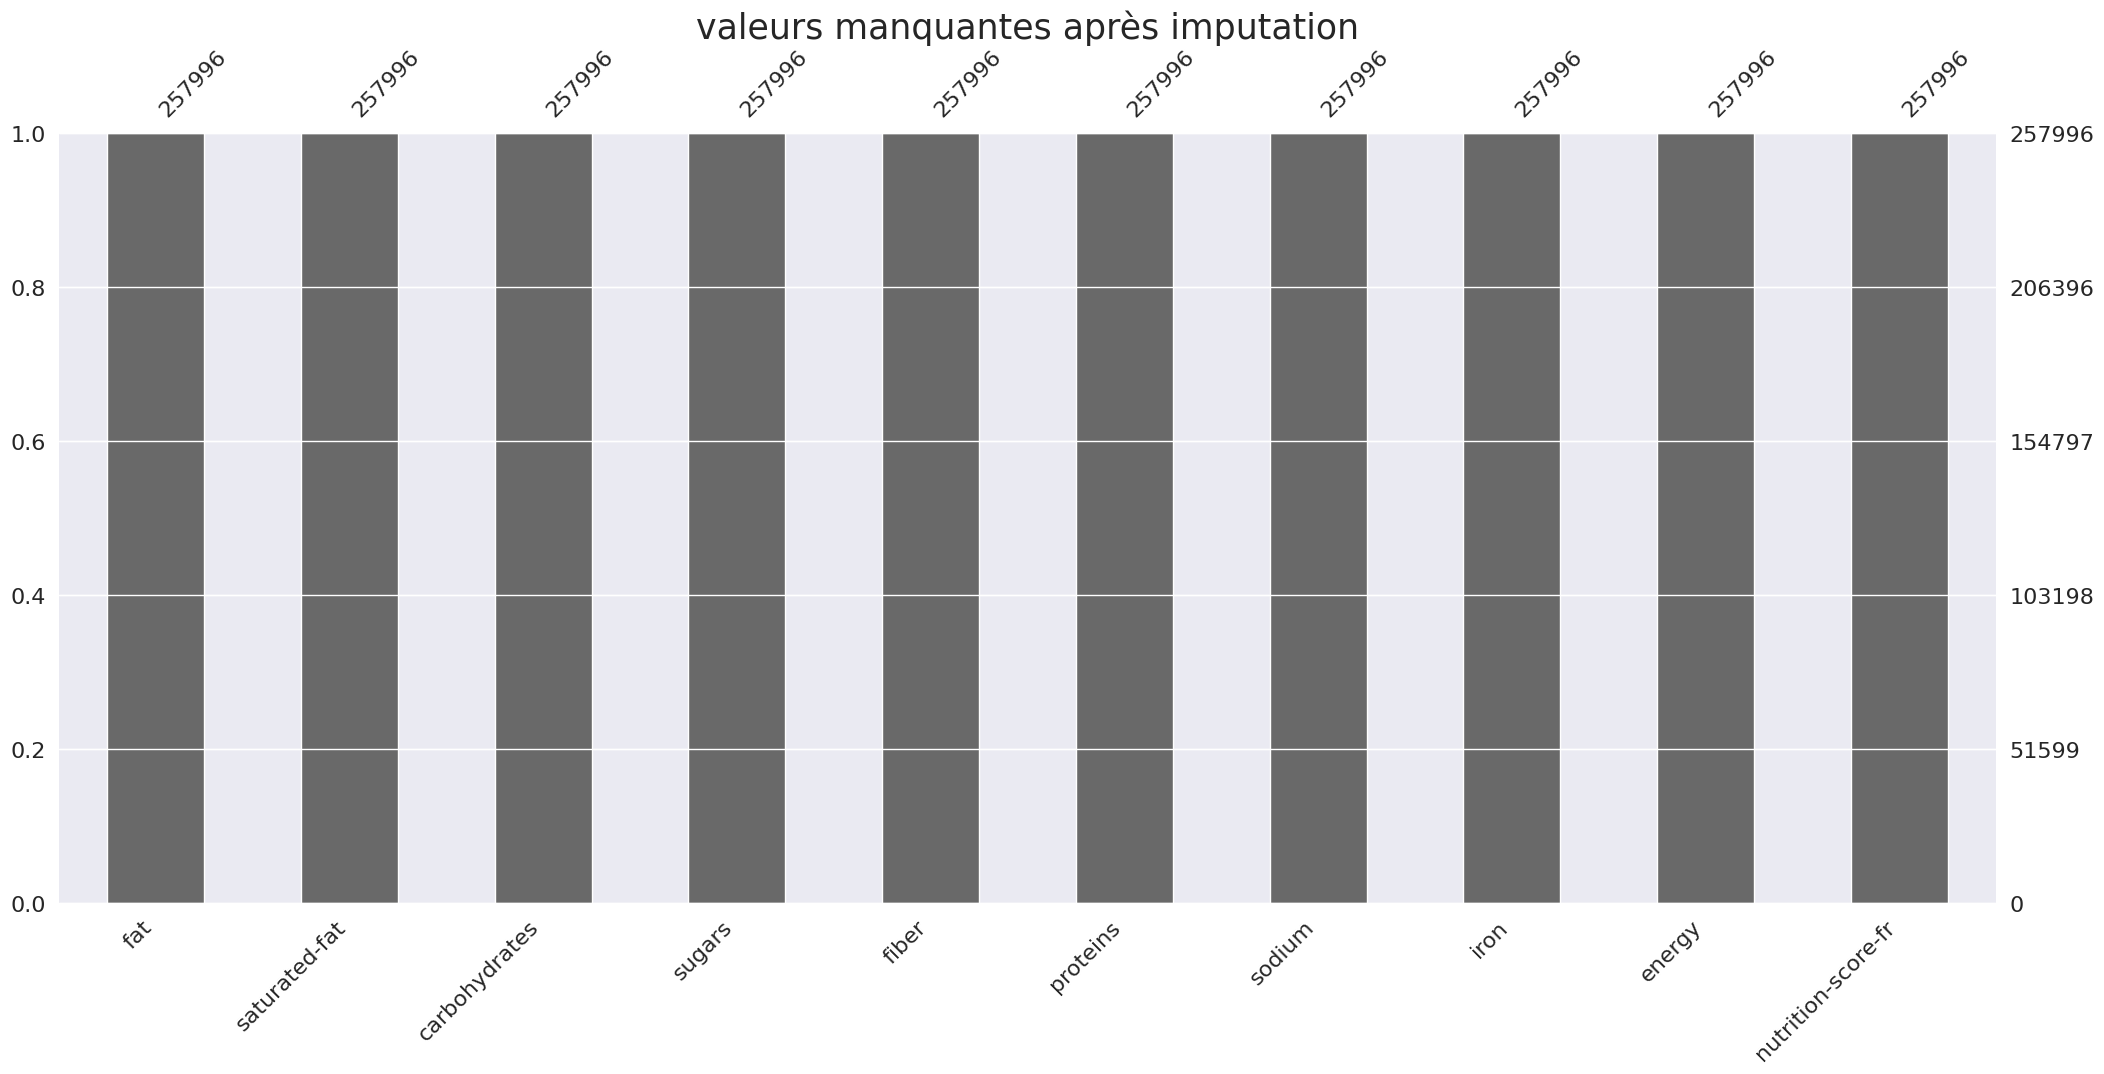

In [72]:
msno.bar(dfNutrimentsImputed)
plt.title("valeurs manquantes après imputation", fontsize=25)
plt.show()

> nous pouvons voir qu'il n'y a plus de valeurs manquantes

## Sauvegarde des DataFrames

In [73]:
# Sauvegarde des Df
dfGeneral.to_csv(dossierExport+'/dfGeneral.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfNutriments.to_csv(dossierExport+'/dfNutriments.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfNutrimentsImputed.to_csv(dossierExport+'/dfNutrimentsImputed.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfSpecsFr.to_csv(dossierExport+'/dfSpecsFr.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfTags.to_csv(dossierExport+'/dfTags.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfEnergy.to_csv(dossierExport+'/dfEnergy.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
# libération mémoire
dfTags=pd.DataFrame()
dfEnergy=pd.DataFrame()
dfNutriments_new=pd.DataFrame()
dfImputer=pd.DataFrame()
dfImputer_transorm=pd.DataFrame()

In [74]:
#dfNutriments = pd.read_csv(dossierData+'/Etape3'+'/dfNutriments.csv', sep='|', lineterminator='\n', encoding='utf-8')

# Etape 4 - Analyses uni et bi-variées

In [75]:
# definition variables
dossierImport=dossierData+'/Etape3'
dossierExport=dossierData+'/Etape4'

# on cree le repertoire Data si il n'existe pas
CreationDir(dossierExport)

## Heatmap des corrélations avant imputation

Temps d'execution : 0.3 s


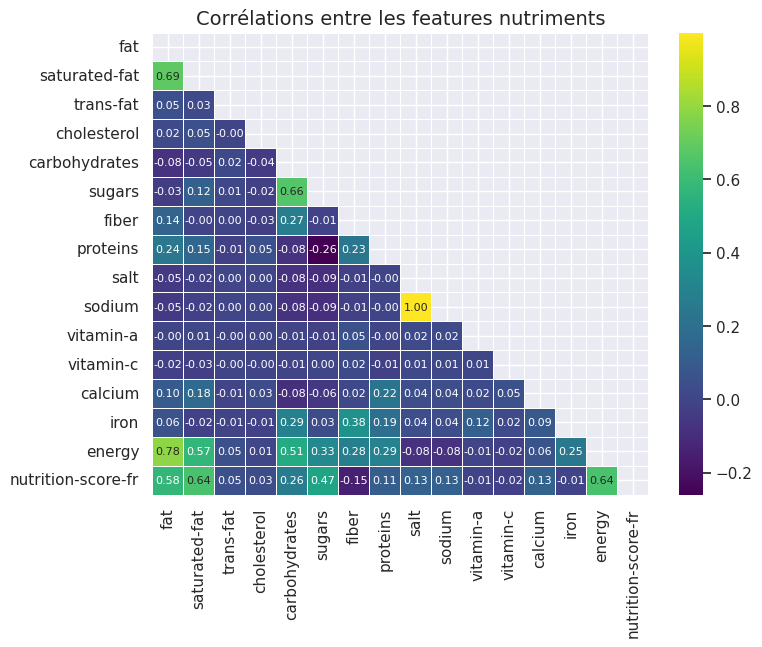

In [76]:
start = time.time()
correlation_nutriment = dfNutriments.corr()
plt.figure(figsize = (8,6))
plt.title("Corrélations entre les features nutriments", fontsize=14)
plt.rcParams.update({'font.size': 8})
mask = np.triu(np.ones_like(correlation_nutriment, dtype=bool))
sns.heatmap(correlation_nutriment, cmap ='viridis', linewidths = 0.5, annot = True, fmt=".2f", mask = mask) 
print('Temps d\'execution :',round(time.time() - start,1),'s')

## Heatmap des corrélations après imputations

<Axes: title={'center': 'Corrélation entre les features nutriments imputés'}>

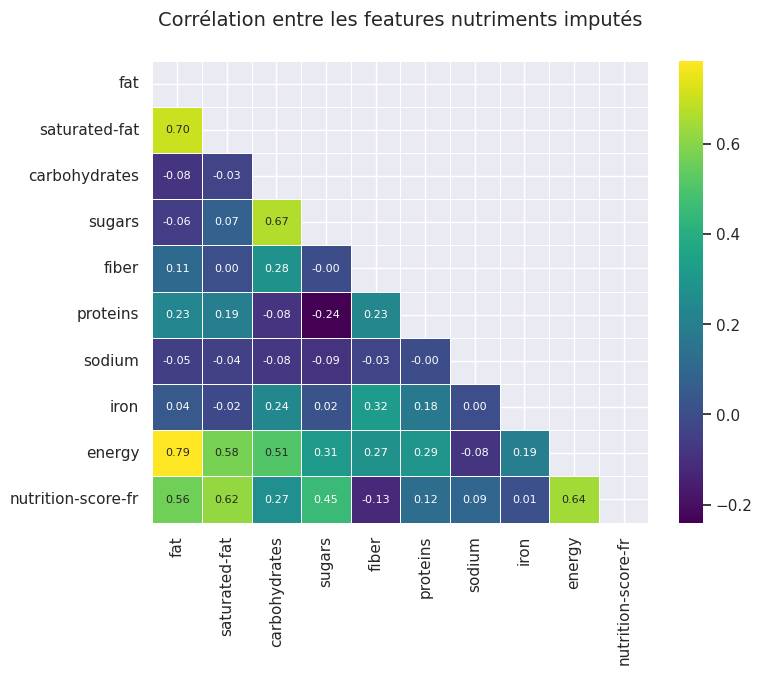

In [77]:
correlation_nutriment = dfNutrimentsImputed.corr()
plt.figure(figsize = (8,6))
plt.title("Corrélation entre les features nutriments imputés", fontsize=14, pad=25)
plt.rcParams.update({'font.size': 8})
mask = np.triu(np.ones_like(correlation_nutriment, dtype=bool))
sns.heatmap(correlation_nutriment, cmap ='viridis', linewidths = 0.5, annot = True, fmt=".2f", mask = mask) 

> Ce heatmap nous montre de nombreuses corrélations sucres/glucides énergie/nutri-score/graisses/glucides

## Relation entre le nutri-score et l'énergie

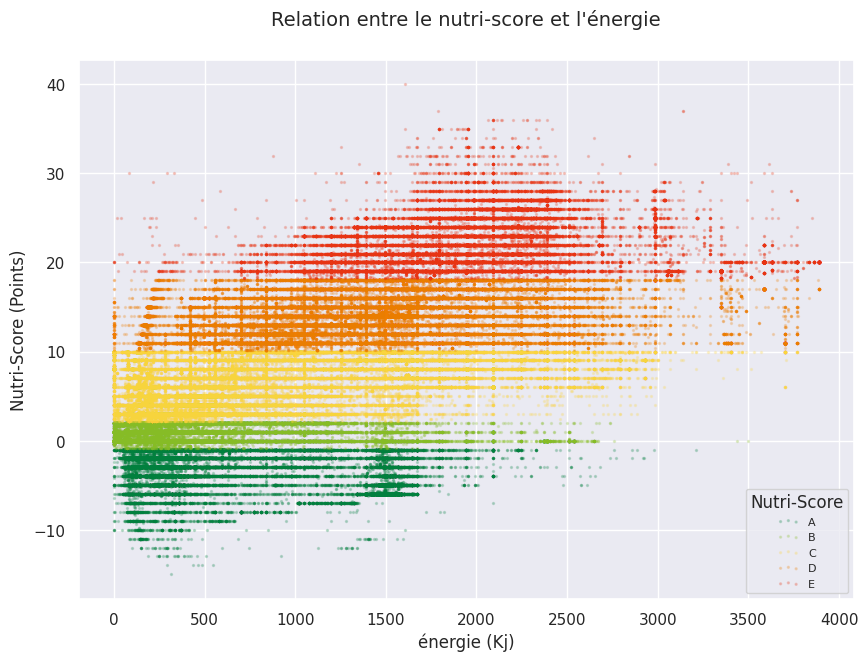

In [78]:
plt.figure(figsize = (10,7))
plt.title("Relation entre le nutri-score et l'énergie", fontsize=14, pad=25)
plt.rcParams.update({'font.size': 8})
plt.xlabel("énergie (Kj)")
plt.ylabel("Nutri-Score (Points)")
x=dfNutrimentsImputed['energy']
y=dfNutrimentsImputed['nutrition-score-fr']
A = y<=-1
B = (y>-1) & (y<=2)
C = (y>2) & (y<=10)
D = (y>10) & (y<=18)
E = (y>18)
scoreA=plt.scatter(x[A], y[A], color='#01803E', s=2, alpha=0.2)
scoreB=plt.scatter(x[B], y[B], color='#86BC26', s=2, alpha=0.2)
scoreC=plt.scatter(x[C], y[C], color='#FCD43D', s=2, alpha=0.2)
scoreD=plt.scatter(x[D], y[D], color='#EF7D00', s=2, alpha=0.2)
scoreE=plt.scatter(x[E], y[E], color='#E73413', s=2, alpha=0.2)
plt.legend((scoreA,scoreB,scoreC,scoreD,scoreE),
           ('A','B','C','D','E'),
           scatterpoints=3, loc='lower right', title="Nutri-Score", fontsize=8)

> Nous voyons bien un lien entre nutri-score et energie mais d'autres composantes sont en jeu

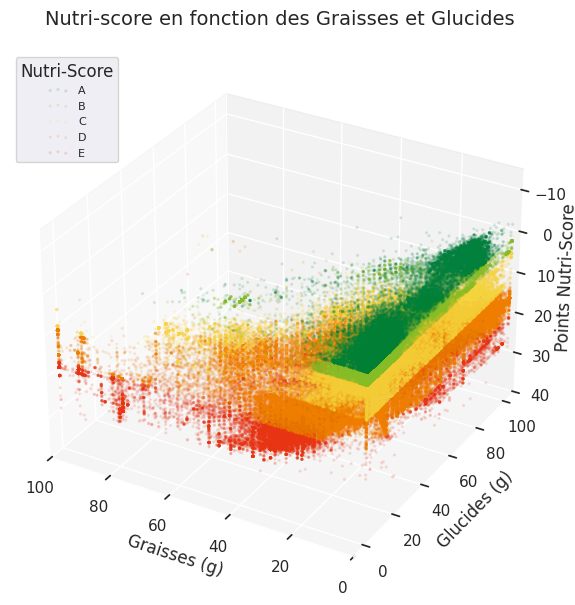

In [79]:
f=plt.figure(figsize = (10,7))
f.set_figwidth=20
f.set_figheight=20
ax=f.add_subplot(projection='3d')
x=dfNutrimentsImputed['fat']
y=dfNutrimentsImputed['carbohydrates']
z=dfNutrimentsImputed['nutrition-score-fr']
w=z
A = z<=-1
B = (z>-1) & (z<=2)
C = (z>2) & (z<=10)
D = (z>10) & (z<=18)
E = (z>18)

plt.title("Nutri-score en fonction des Graisses et Glucides", fontsize=14, pad=20)
scoreE=ax.scatter(x[E], y[E], w[E], color='#E73413', s=2, alpha=0.1)
scoreD=ax.scatter(x[D], y[D], w[D], color='#EF7D00', s=2, alpha=0.1)
scoreC=ax.scatter(x[C], y[C], w[C], color='#FCD43D', s=2, alpha=0.1)
scoreB=ax.scatter(x[B], y[B], w[B], color='#86BC26', s=2, alpha=0.1)
scoreA=ax.scatter(x[A], y[A], w[A], color='#01803E', s=2, alpha=0.1)
ax.set_xlim(100,0)
ax.set_zlim(40,-15)
plt.legend((scoreA,scoreB,scoreC,scoreD,scoreE),
           ('A','B','C','D','E'),
           scatterpoints=3, loc='upper left', title="Nutri-Score", fontsize=8)
ax.set_xlabel('Graisses (g)')
ax.set_ylabel('Glucides (g)')
ax.set_zlabel('Points Nutri-Score')
ax.zaxis.labelpad=-0.2
ax.set_facecolor('white')

plt.show()

> Le nutri-score est plus influencé par les graisses que par les glucides

## Corrélations entre les features nutriments et la categorie

In [80]:
dfMainCateg=dfNutrimentsImputed.join(dfSpecsFr[['main_category_fr','MainFr2Study']], on=None, how='left', sort=False, validate=None)
#print(dfMainCateg.shape)
dfMainCateg=dfMainCateg[dfMainCateg['MainFr2Study']==True]
#print(dfMainCateg.shape)
ValuesCateg=pd.DataFrame(dfMainCateg['main_category_fr'].value_counts(sort=True,ascending=False))
ValuesCateg=ValuesCateg.reset_index()
ValuesCateg['id']=range(1, 1+len(ValuesCateg))

ValuesCateg.to_csv(dossierExport+'/ValuesCateg.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')

dfMainCateg['idCateg']=dfMainCateg['main_category_fr'].map(ValuesCateg.set_index('main_category_fr')['id'])
if 'main_category_fr' in dfMainCateg.columns:
    dfMainCateg=dfMainCateg.drop('main_category_fr',axis=1)
if 'MainFr2Study' in dfMainCateg.columns:
    dfMainCateg=dfMainCateg.drop('MainFr2Study',axis=1)
#dfMainCateg

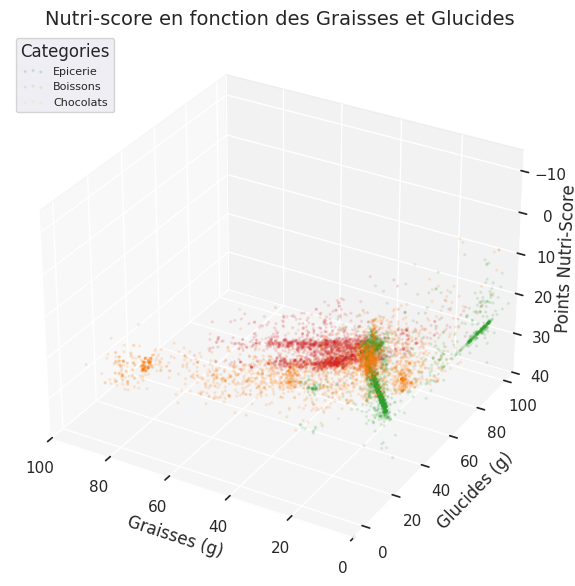

In [81]:
f=plt.figure(figsize = (10,7))
f.set_figwidth=20
f.set_figheight=20
ax=f.add_subplot(projection='3d')
X='fat'
Y='carbohydrates'
Z='nutrition-score-fr'

W = "idCateg" 

sous_echantillon=dfMainCateg
modalites = sous_echantillon[W].unique()
modalites = range(1,4)
groupes = []
labels = []
cm = plt.get_cmap('tab10')
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[W]==m][W])
    labels.append(ValuesCateg[ValuesCateg['id']==m]['main_category_fr'].values[0])
    ax.scatter(sous_echantillon[sous_echantillon[W]==m][X],sous_echantillon[sous_echantillon[W]==m][Y], sous_echantillon[sous_echantillon[W]==m][Z], color=cm(m), s=2, alpha=0.1)

plt.title("Nutri-score en fonction des Graisses et Glucides", fontsize=14)
ax.set_xlim(100,0)
ax.set_zlim(40,-15)
plt.legend((scoreA,scoreB,scoreC,scoreD,scoreE),
           labels,
           scatterpoints=3, loc='upper left', title="Categories", fontsize=8)



ax.set_xlabel('Graisses (g)')
ax.set_ylabel('Glucides (g)')
ax.set_zlabel('Points Nutri-Score')
ax.set_facecolor('white')
ax.zaxis.labelpad=-0.2 
plt.show()

> Test de représentation des nutri-scores graisses glucides en fonction des catégories de produits

## Relation entre les glucides et le sucre

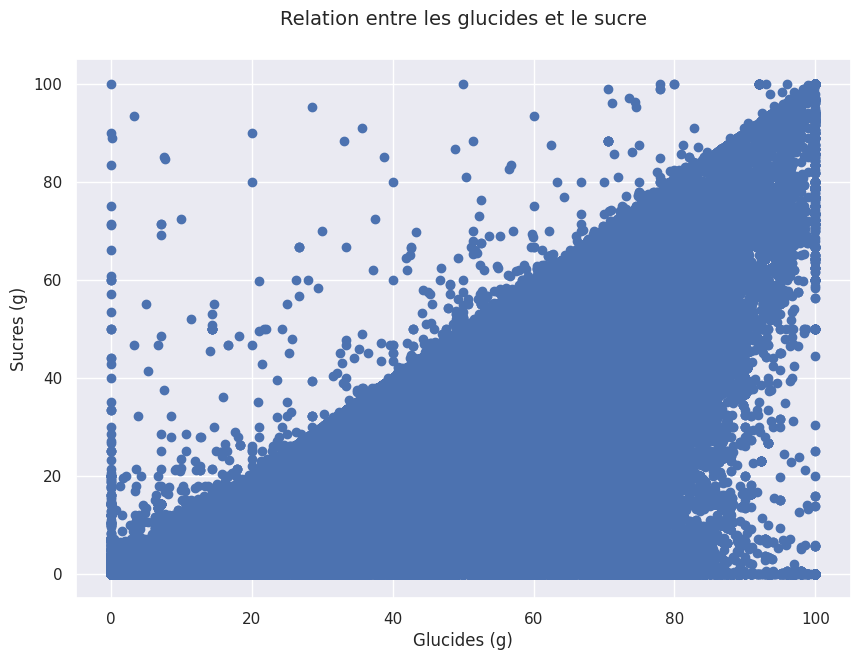

In [82]:
plt.figure(figsize = (10,7))
plt.title("Relation entre les glucides et le sucre", fontsize=14, pad=25)
plt.rcParams.update({'font.size': 8})
plt.xlabel("Glucides (g)")
plt.ylabel("Sucres (g)")
plt.scatter(dfNutrimentsImputed['carbohydrates'],dfNutrimentsImputed['sugars'])
plt.show()

> Forte corrélation entre glucides et sucres avec une limite superieure (en diagonale)

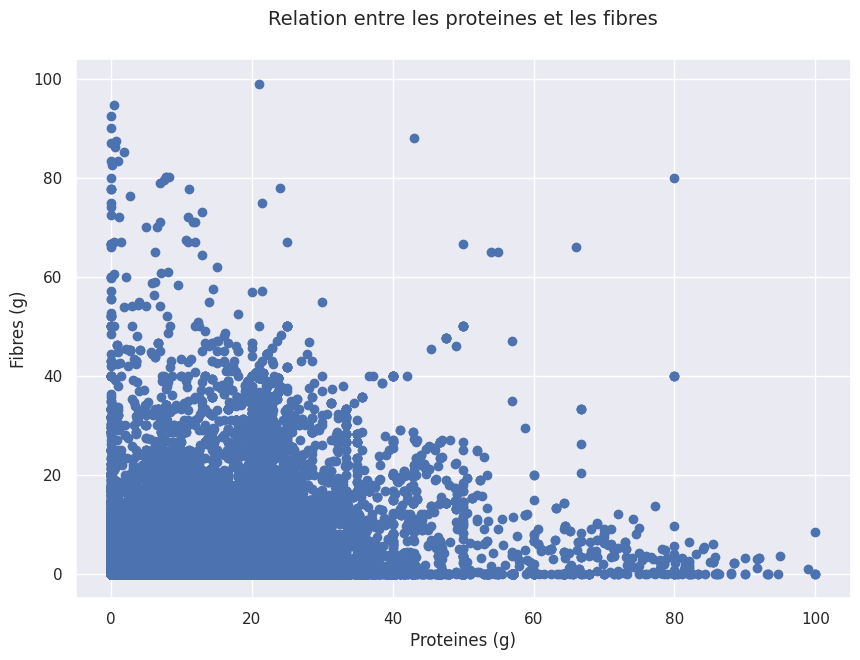

In [83]:
plt.figure(figsize = (10,7))
plt.title("Relation entre les proteines et les fibres", fontsize=14, pad=25)
plt.rcParams.update({'font.size': 8})
plt.xlabel("Proteines (g)")
plt.ylabel("Fibres (g)")
plt.scatter(dfNutrimentsImputed['proteins'],dfNutrimentsImputed['fiber'])

> Plus les proteines augmentent plus les fibres diminuent et inversement

## Sauvegarde des DataFrames

In [84]:
# Sauvegarde des Df
dfGeneral.to_csv(dossierExport+'/dfGeneral.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfNutriments.to_csv(dossierExport+'/dfNutriments.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfNutrimentsImputed.to_csv(dossierExport+'/dfNutrimentsImputed.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfSpecsFr.to_csv(dossierExport+'/dfSpecsFr.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfMainCateg.to_csv(dossierExport+'/dfMainCateg.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')

# Etape 5 - Analyse multi-variée

In [85]:
# definition variables
dossierImport=dossierData+'/Etape4'
dossierExport=dossierData+'/Etape5'

# on cree le repertoire Data si il n'existe pas
CreationDir(dossierExport)

In [86]:
def CercleCorrel(Pca,x,y,Colonnes):
    """
    # Fonction de représentation du cercle des corrélations
    # Pca      : les données Pca déjà entrainée
    # x        : index de la première composante
    # y        : index de la deuxième composante
    # Colonnes : liste des colonnes pour labels des flèches
    """
    fig, ax = plt.subplots(figsize=(8, 7))
    # Ajout du titre
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1), pad=25)
    # Ajout des axes + pourcentage d'inertie
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*Pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*Pca.explained_variance_ratio_[y],1)))
    plt.axis('equal')
    # Ajout du cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  
    # Ajout des axes centraux
    plt.plot([-1, 1], [0, 0], color='grey', ls='-.')
    plt.plot([0, 0], [-1, 1], color='grey', ls='-.')
    # Tracé des flèches
    for i in range(0, Pca.components_.shape[1]):
        ax.arrow(0,0,
             Pca.components_[x, i],  #Pca x
             Pca.components_[y, i],  #Pca y
             head_width=0.05,
             head_length=0.05, 
             width=0.02,
             length_includes_head=True)
        plt.text(Pca.components_[x, i] + 0.03,
             Pca.components_[y, i] + 0.03,
             Colonnes[i])
    plt.show(block=False)

def Eboulis(Pca,n_components):
    # Représentation de l'éboulis des valeurs propres
    eboulis = (Pca.explained_variance_ratio_*100).round(2)
    eboulisCumulé = eboulis.cumsum().round()
    x_list = range(1, n_components+1)
    plt.bar(x_list, eboulis)
    plt.plot(x_list, eboulisCumulé,c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres", pad=20)
    plt.show(block=False)

def Composantes(Pca,n_components,colonnesAnalyse):
    # Composantes de l'ACP
    x_list = range(1, n_components+1)
    Pcs = pd.DataFrame(Pca.components_)
    Pcs.columns = colonnesAnalyse
    Pcs.index = [f"F{i}" for i in x_list]
    display(Pcs.round(4).T)
    return Pcs

def HeatMap(Pcs):
    # Représentation de la PCA avec une heatMap
    fig, ax = plt.subplots(figsize=(20, 6))
    sns.heatmap(Pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

## Analyse en composante principale (258 042 individus)

In [87]:
# réalisation de l'ACP
X = dfNutrimentsImputed.values
indexAnalyse = dfNutrimentsImputed.index
colonnesAnalyse = dfNutrimentsImputed.columns
scaler = StandardScaler() # mise a l'echelle
scaler.fit(X)
X_scaled = scaler.transform(X)
#pd.DataFrame(X_scaled).describe().round(2).loc[["mean", "std"], :] # verification des moyennes a 0 et écarts types a 1
n_components = 8 # Selection des 8 premiéres composantes
Pca = PCA(n_components=n_components)
Pca.fit(X_scaled) # Entrainement de l'ACP
#Pca.explained_variance_ratio_ # Verification de la variance des données

PCA(n_components=8)

### Représentation de l'éboulis des valeurs propres

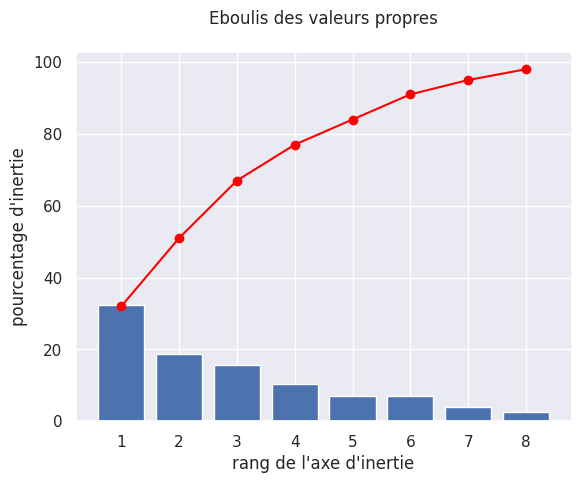

In [88]:
Eboulis(Pca,n_components)

> Nous obtenons 51,2 % d'inertie avec les deux premières composantes

### Composantes de la PCA

In [89]:
Pcs=Composantes(Pca,n_components,colonnesAnalyse)

,F1,F2,F3,F4,F5,F6,F7,F8
fat,0.4380,0.3434,-0.0144,-0.0811,0.1185,0.2732,-0.3305,-0.3056
saturated-fat,0.4143,0.2939,-0.1516,-0.0599,0.1243,0.1147,0.5305,0.6231
carbohydrates,0.2387,-0.5994,0.0732,0.0329,-0.1603,-0.0336,-0.2983,0.4869
sugars,0.2227,-0.5490,-0.2746,0.0075,-0.0897,-0.1355,0.3341,-0.3179
fiber,0.1228,-0.1414,0.5974,-0.0120,-0.3045,0.5476,0.3857,-0.2072
proteins,0.1634,0.2813,0.4255,0.0386,-0.4587,-0.6814,0.0604,0.0028
sodium,-0.0372,0.0849,-0.0465,0.9625,-0.1041,0.1491,-0.0513,0.0718
iron,0.1108,-0.1662,0.5082,0.1624,0.7843,-0.2287,0.0654,-0.0363
energy,0.5221,-0.0307,0.0891,-0.0346,-0.0787,0.0833,-0.4547,0.0445
nutrition-score-fr,0.4493,0.0048,-0.2997,0.1821,0.0391,-0.2170,0.2066,-0.3590


### Représentation de la PCA avec une heatMap

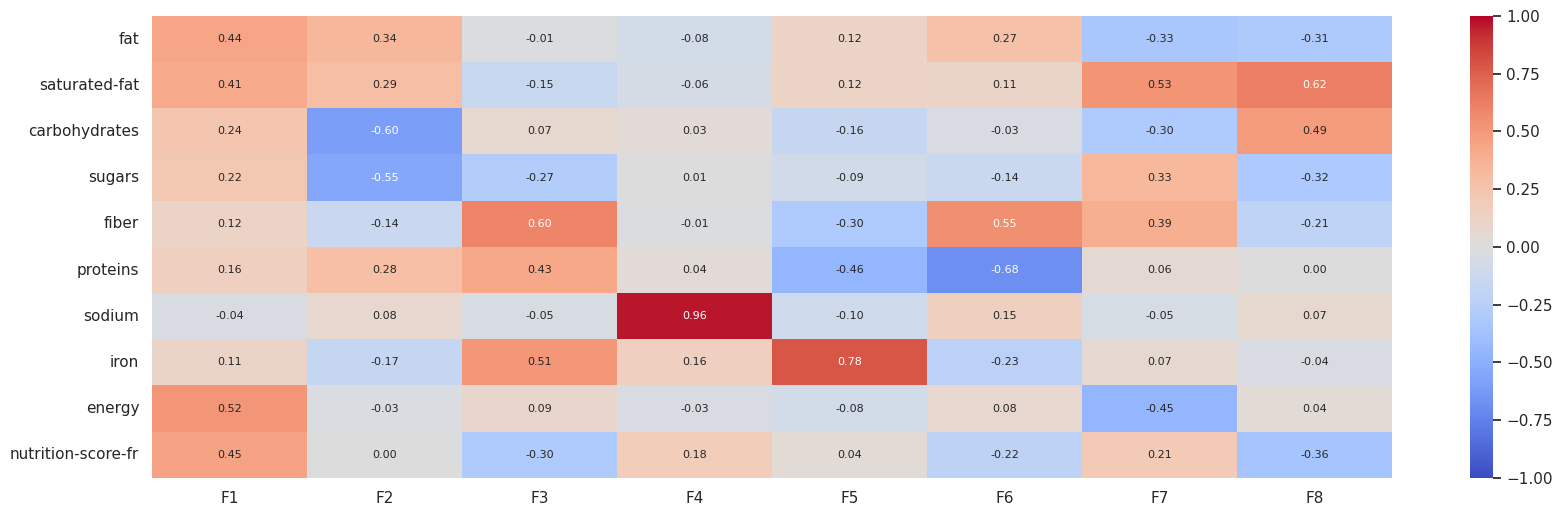

In [90]:
HeatMap(Pcs)

### Cercles de corrélations

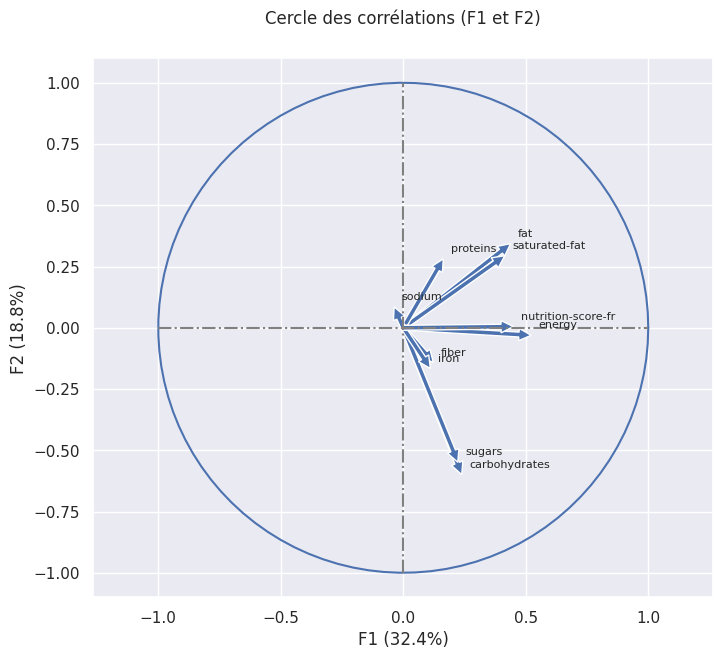

In [91]:
CercleCorrel(Pca,0,1,colonnesAnalyse)

> 51% d'inertie sur ce graphique avec une forte corrélation entre Sucres/Glucides/Energie/Graisses/Nutriscore

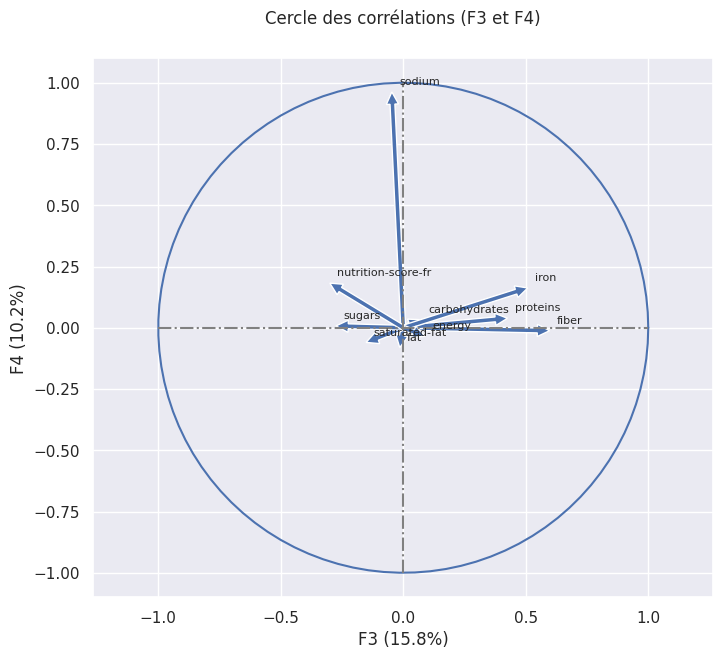

In [92]:
CercleCorrel(Pca,2,3,colonnesAnalyse)

> 25% d'inertie sur ce graphique avec une relation forte entre F4 et le Sodium

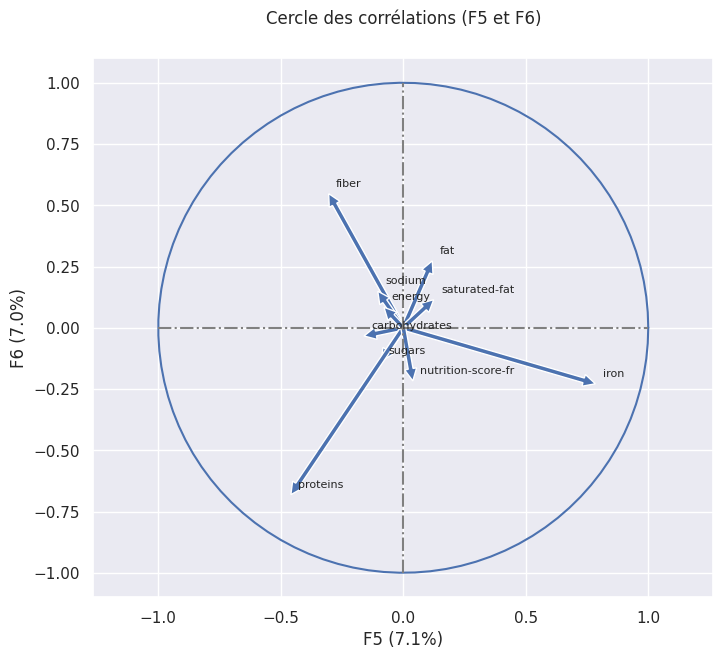

In [93]:
CercleCorrel(Pca,4,5,colonnesAnalyse)

> Relations plus complexes ne pouvant êtres interprétées.


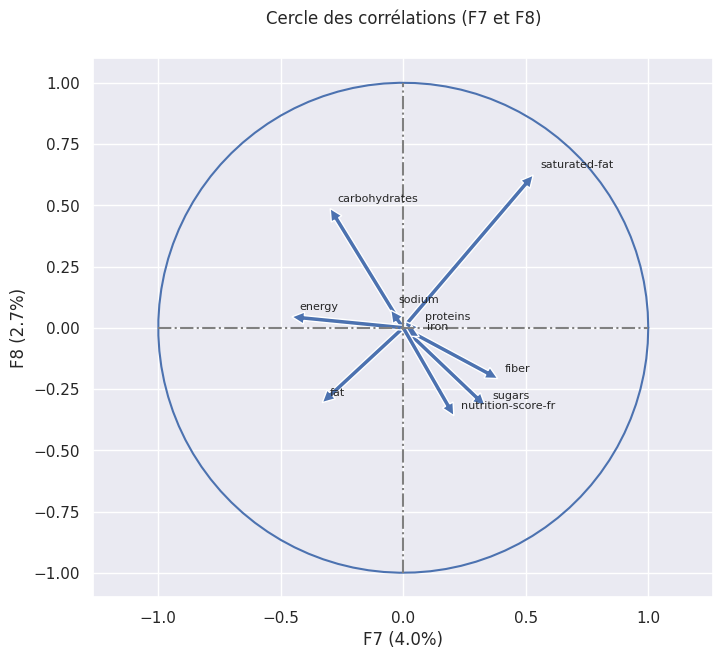

In [94]:
CercleCorrel(Pca,6,7,colonnesAnalyse)

> Relations plus complexes ne pouvant êtres interprétées.


## Relation entre le Nutri-Score et les principales familles de produits

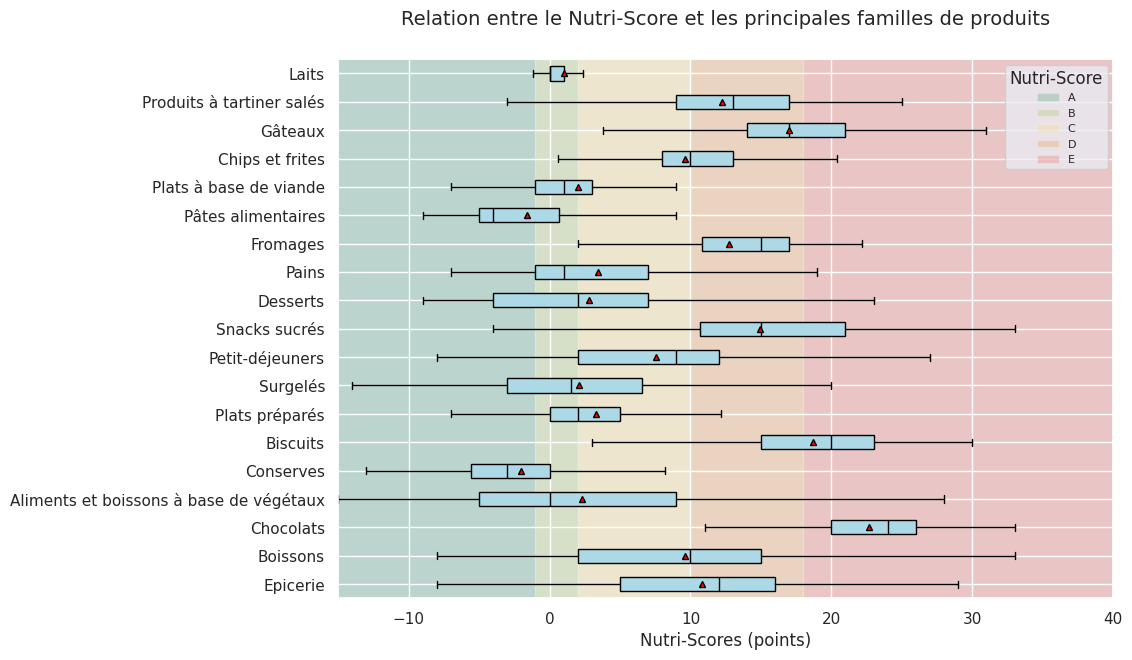

In [95]:
X = "idCateg" # qualitative
Y = "nutrition-score-fr" # quantitative
sous_echantillon=dfMainCateg
modalites = sous_echantillon[X].unique()
modalites = range(1,20)
groupes = []
labels = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])
    labels.append(ValuesCateg[ValuesCateg['id']==m]['main_category_fr'].values[0])
# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'markeredgecolor':'black',
            'markerfacecolor':'red', 'markersize': 4}

plt.figure(figsize = (10,7))
plt.title("Relation entre le Nutri-Score et les principales familles de produits", fontsize=14, pad=25)
plt.rcParams.update({'font.size': 8})
plt.xlabel("Nutri-Scores (points)")
plt.ylabel("")
points_debut = [-15,-1,2,10,18]
points_fin = [-1,2,10,18,40]
points_color = ['#01803E', '#86BC26', '#FCD43D', '#EF7D00', '#E73413'] 
points_categ=[*'ABCDE']
for i in range(0,5):
    plt.axvspan(points_debut[i], points_fin[i], facecolor=points_color[i], alpha=0.2, zorder=-10, label=points_categ[i])

box = plt.boxplot(groupes, tick_labels=labels, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops, widths=0.5)
plt.setp(box["boxes"], facecolor='lightblue')
plt.xlim([-15, 40])
plt.legend(title="Nutri-Score", fontsize=8)
plt.show()



> Ce graphique montre que des catégories de produits ont des meilleurs nutri-scores que d'autres

## Rapports de corrélations entre les catégories de produits et le sodium, Glucides, Fibres, Proteines

In [96]:
def rapportCorrel(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y]) # Variation totale
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes]) #Variation interclasse
    print(round(SCE/SCT,2))
    print("")

X = "idCateg"
for Y in dfMainCateg.columns :
    if Y == 'idCateg' :
        quit
    print("Rapport de corrélation entre Catégories de produit et",Y)
    rapportCorrel(dfMainCateg[X],dfMainCateg[Y])


Rapport de corrélation entre Catégories de produit et fat
0.7

Rapport de corrélation entre Catégories de produit et saturated-fat
0.68

Rapport de corrélation entre Catégories de produit et carbohydrates
0.73

Rapport de corrélation entre Catégories de produit et sugars
0.63

Rapport de corrélation entre Catégories de produit et fiber
0.31

Rapport de corrélation entre Catégories de produit et proteins
0.65

Rapport de corrélation entre Catégories de produit et sodium
0.49

Rapport de corrélation entre Catégories de produit et iron
0.1

Rapport de corrélation entre Catégories de produit et energy
0.73

Rapport de corrélation entre Catégories de produit et nutrition-score-fr
0.59

Rapport de corrélation entre Catégories de produit et idCateg
1.0



## Sauvegarde des DataFrames

In [97]:
# Sauvegarde des Df
dfGeneral.to_csv(dossierExport+'/dfGeneral.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfNutriments.to_csv(dossierExport+'/dfNutriments.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfNutrimentsImputed.to_csv(dossierExport+'/dfNutrimentsImputed.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')
dfMainCateg.to_csv(dossierExport+'/dfMainCateg.csv', index=False, sep='|', lineterminator='\n', encoding='utf-8')